# `simDeer.R`
Copies the code in `simDeer.R` into a notebook to display outputs.  See code there for comments.

In [1]:
library(MASS)

In [2]:
DATA_DIR = '~/Learning/diseaseSimulator/data'

# Step 1. Set Constant Parameters

# Dimensions to map
# Grid will be broken down into squares of MAP_UNIT x MAP_UNIT km for
# tracking soil infectiousness; resolution for heatmaps
MAP_UNIT = 1

# Diminsions for x and y coordinates
MAP_X = c(0, 100)
MAP_Y = c(0, 100)

# size square lengths (in same units as MAP_X, and MAP_Y) of subdivisions of 
# map. This will serve to treat density as a local phenomenon for deaths, as 
# well as to calculate local statistics separately, and to target specific
# regions for culling, for example. 
# In the example that follows, a subdivision of size 10 (10x10 = 100 sq. km) 
# is approximately the size of a township.
SUBDIVISION = 10

# Proportions of each age/sex group 
# The numbers here are based on a large date set from Northern IL, where the 
# age classes are: young--fawns (age < 1 yr), adolescents--yealings (1 ≤ age 
# < 2 yr), and adults (age ≥ 2)
M_YOUNG = 0.212
M_ADOLESC = 0.088
M_ADULT = 0.087
F_YOUNG = 0.186
F_ADOLESC = 0.084
F_ADULT = 0.343


# Disease
# Inital proportion of population with the disease (on [0, 1]).
INITIAL_PREVALENCE = 0.01

# Probability of two animals contacting if their ranges overlap
CONTACT_PROB = 1 
# Probability of diseased animal infecting another contact is made
INFECT_PROB = 0.08

# Units are arbitary, but a value of 1 is equal to one iteration of the 
# simulation
MAX_LIFE_EXPECTANCY = 2.0 # That is, max years lived after infected 


# Population densities
# Whole area (in numbers per square unit in MAP_X, MAP_Y units)
DENSITY =  4.5
# For the example, this number is for Illinois Population Densities 
# (ROSEBERRY & WOOLFE (1998)) in deer/sq.km

MAX_DENSITY = 9
# For Illinois deer, Roseberry & Woolfe 1998 estimated around 16 in ideal 
# habitat; 9 is a compromise between current est of 4.5 and max of 16


# Dispersion and Migration
# Illinois Mean Dispersal Distances in km (From Nixon)
# Mean dispersal distance by sex
M_MEAN_DISPERSAL_DIST = 40.9
F_MEAN_DISPERSAL_DIST = 49.0

# Probability of dispersal by sex and age class (assuming not already 
# dispersed)
M_YOUNG_DISPERSAL_PROB = 0.51
F_YOUNG_DISPERSAL_PROB = 0.50
F_ADOLESC_DISPERSAL_PROB = 0.21

# Proportion of animals migrating by age class
F_ADOLESC_MIGRATE_PROP = 0.196
F_ADULT_MIGRATE_PROP = 0.196
# Mean and standard deviation for distance migrated
F_ADOLESC_MIGRATE_MEAN = 20.8
F_ADOLESC_MIGRATE_SD = 7.9
F_ADULT_MIGRATE_MEAN = 7.3
F_ADULT_MIGRATE_SD = 5.2

# Homeranges-- (area in sq. units, means and sds under different conditions)
M_ADOLESC_POSTRUT_MEAN = 4.89
M_ADOLESC_POSTRUT_SD = 0.78
M_ADOLESC_PRERUT_MEAN = 3.00
M_ADOLESC_PRERUT_SD = 1.90
M_ADOLESC_RUT_MEAN = 4.91
M_ADOLESC_RUT_SD = 1.92
M_ADULT_POSTRUT_MEAN = 4.40
M_ADULT_POSTRUT_SD = 0.57
M_ADULT_PRERUT_MEAN = 3.23
M_ADULT_PRERUT_SD = 1.39
M_ADULT_RUT_MEAN = 4.80
M_ADULT_RUT_SD = 1.96
F_ADOLESC_ADULT_POSTBREEDING_MEAN = 1.77
F_ADOLESC_ADULT_POSTBREEDING_SD = 0.93
F_ADOLESC_ADULT_PARTURITION_MEAN = 0.55
F_ADOLESC_ADULT_PARTURITION_SD = 0.38
F_ADOLESC_ADULT_PREBREEDING_MEAN = 1.10
F_ADOLESC_ADULT_PREBREEDING_SD = 0.78

# Annual Mortality (not including culling for disease control)
M_YOUNG_MORT = 0.54 
M_ADOLESC_MORT = 0.38
M_ADULT_MORT = 0.39
F_YOUNG_MORT = 0.59 
F_ADOLESC_MORT = 0.62
F_ADULT_MORT = 0.71

# Reproduction
# Avg. births per mother
YOUNG_BIRTH_RATE = 0.28
ADOLESC_BIRTH_RATE = 1.36
ADULT_BIRTH_RATE = 1.72
# Avg. litter size per pregnant mother
YOUNG_LITTER_SIZE_MEAN = 1.3 
ADOLESC_LITTER_SIZE_MEAN = 1.8
ADULT_LITTER_SIZE_MEAN = 2.0
# Proportion of each sex among all newborns
M_BIRTH_PROP = 0.52
F_BIRTH_PROP = 0.48

# Proportion of females in each age class conceiving
YOUNG_PREG_RATE = 0.22
ADOLESC_PREG_RATE = 0.77
ADULT_PREG_RATE = 0.87

# Soil Load Erosion
# Infectious material in the environment is assumed to decay exponentially.
# If infectious load in the soil is x at time t, it will be x * 
# SOIL_RETENTION_RATE at t + 1
SOIL_RETENTION_RATE = 0.9#9

# Coefficient for soilInfect (see below--in short, larger scalars make soil 
# more infectious)
SCALAR = 2

# Colors
# Define colors to be used to plot each sex and age-class
COLOR_M_YNG = 'cyan'
COLOR_M_ADLSC = '#5050FF'
COLOR_M_ADLT = '#000077'
COLOR_M_NEO = '#00FF00'
COLOR_F_YNG = 'lightpink'
COLOR_F_ADLSC = 'hotpink'
COLOR_F_ADLT = '#FF0000'
COLOR_F_NEO = '#FFFF00'

COLOR_DEAD = rgb(0, 0, 0, 0.5)
colorMatrix = matrix(
  c(COLOR_M_ADLT, COLOR_F_ADLT, COLOR_M_ADLSC, COLOR_F_ADLSC, 
    COLOR_M_YNG, COLOR_F_YNG, COLOR_M_NEO, COLOR_F_NEO),  
  nrow = 2)
rownames(colorMatrix) = c('M', 'F')
colnames(colorMatrix) = c('Ad', 'Adol', 'Yng','neo')
# The matrix is just to access colors more easily in functions below
colorMatrix

Ad      Adol    Yng       neo    
M #000077 #5050FF cyan      #00FF00
F #FF0000 hotpink lightpink #FFFF00

In [3]:
# Step 2. Populate the Map
#=========================================================================#
#                                                                         #
# This function creates the data.frame for animal agents, and populates a #
# map.                                                                    #
#                                                                         #
# @param mapX, mapY: numeric vectors of length 2 specifying the range of  #
#                    coordinates to be mapped                             #
# @param minPrev1: boolean; if TRUE at least one animal must be infected  #
# All other parameters are as described in the constant parameters above. #
# @return Animal: a data.frame of all animals in the popultion.           #
# Each animal is assigned each of the following:                          #
#   age                                                                   #
#   sex                                                                   #
#   diseaseStatus = neg at initialization                                 #
#   yearsInfected	(tracks time since infected to limit lifespan)        #
#   xSummer (summer x coordinate--indicates center of range)              #
#   ySummer, xWinter, yWinter                                             #
#   dispersed (boolean: TRUE if previously dispersed; keeps dispersal     #
#              limited to a single occasion)                              #
#   mother (ID of mother: enables movement of young and mothers together) #
#                                                                         #
# This version assumes a homogeneous landscape, but rivers and other      #
# habitat features such as variable density limits may be added later     #
#                                                                         #
#=========================================================================#

populate = function(
    mapX, mapY, density = DENSITY, MYng = M_YOUNG, MAdol = M_ADOLESC, 
    MAd = M_ADULT, FYng = F_YOUNG, FAdol = F_ADOLESC, FAd = F_ADULT, 
    prevalence = INITIAL_PREVALENCE, minPrev1 = T) {
  # Make sure proprtions sum to 1:
  propSum = MYng + MAdol + MAd + FYng + FAdol + FAd
  if (propSum != 1) {
    print(
      paste("Error: Sum of proportions = ", propSum, ". Must sum to 1", 
            sep = ""))
    break
  }
  # Calculate numbers in various classes:
  MProp = MYng + MAdol + MAd
  FProp = FYng + FAdol + FAd
  animalNumber = round(diff(mapX) * diff(mapY) * density, 0)
  MNumber = round(MProp * animalNumber, 0)
  FNumber = animalNumber - MNumber
  MYngNumber = round(MYng * animalNumber, 0)
  MAdolNumber = round(MAdol * animalNumber, 0)
  MAdNumber = MNumber - MYngNumber - MAdolNumber
  FYngNumber = round(FYng * animalNumber, 0)
  FAdolNumber = round(FAdol * animalNumber, 0)
  FAdNumber = FNumber - FYngNumber - FAdolNumber
  posNumber = round(prevalence * animalNumber, 0)
  if (minPrev1 && posNumber == 0) { posNumber = 1 }
  # Construct data frame of animal objects
  Animal = data.frame(
    id = 1:animalNumber, 
    sex = c(rep('M', MNumber), rep('F',FNumber)), 
    age = c(rep('Yng', MYngNumber), rep('Adol', MAdolNumber), 
            rep('Ad', MAdNumber), rep('Yng', FYngNumber), 
            rep('Adol', FAdolNumber), c(rep('Ad', FAdNumber))),
    diseaseStatus = factor(rep('neg', animalNumber), 
                           levels=c('neg', 'pos')), 
    yearsInfected = rep(NA, animalNumber), 
    xWinter = runif(animalNumber, mapX[1], mapX[2]), 
    yWinter = runif(animalNumber, mapY[1], mapY[2]), 
    xSummer = rep(NA, animalNumber), 
    ySummer = rep(NA, animalNumber), 
    dispersed = rep(F, animalNumber), 
    dispersedThisYear = rep(F, animalNumber), 
    vital = factor(rep('alive', animalNumber), levels = c('alive', 'dead'))
  )

  # Randomly select animal to be disease positive
  sickAnimal = sample(animalNumber, posNumber)
  Animal$diseaseStatus[sickAnimal] = 'pos'
  Animal$yearsInfected[sickAnimal] = 0
  
  # Randomly Assign Mothers to Fawns, and set fawn winter x, y coordinates 
  # to match mothers'
  mother = (Animal$age == 'Yng') * 
    sample(Animal$id[Animal$sex == 'F' & Animal$age != 'Yng'], 
           animalNumber, T)
  mother[mother == 0] = NA
  Animal = cbind(Animal, mother)
  
  Animal$xWinter[Animal$age == 'Yng'] = 
    Animal$xWinter[Animal$mother[Animal$age=='Yng']]
  Animal$yWinter[Animal$age=='Yng'] = 
    Animal$yWinter[Animal$mother[Animal$age=='Yng']]

  levels(Animal$age) = c('Ad', 'Adol', 'Yng', 'neo')

  Animal
}

In [4]:
# Populate
Animal.df = populate(mapX = c(45, 55), mapY = c(45, 55))
head(Animal.df)
attach(Animal.df)

id sex age diseaseStatus yearsInfected xWinter  yWinter  xSummer ySummer
1 1  M   Yng neg           NA            47.37779 46.66373 NA      NA     
2 2  M   Yng neg           NA            51.02149 47.14105 NA      NA     
3 3  M   Yng neg           NA            45.08272 49.34106 NA      NA     
4 4  M   Yng neg           NA            53.17650 50.87629 NA      NA     
5 5  M   Yng neg           NA            49.53904 49.67243 NA      NA     
6 6  M   Yng neg           NA            45.55834 52.35229 NA      NA     
  dispersed dispersedThisYear vital mother
1 FALSE     FALSE             alive 377   
2 FALSE     FALSE             alive 280   
3 FALSE     FALSE             alive 436   
4 FALSE     FALSE             alive 403   
5 FALSE     FALSE             alive 284   
6 FALSE     FALSE             alive 414

In [5]:
# Plot Animal Distribution
# Helper functions

#===========================================================================#
# 																			#
# Take x, y coordinates and sex, age, and mortality characteristics of		#
# animals	and add to an existing plot										#
# @params x, y: vectors of x, y coordinates									#
# @params age, sex: vectors of age and sex characteristics of animals		#
# @param color: colors to use for each age/sex class, etc.					#
# @param size: size of point to be plotted (in cex units)					#
# @param mort: boolean; at some points both dead and living animals will be #
#			   present in the data.frame; if TRUE, only animals marked 		#
#			   'alive' will be plotted										#
#																			#
#===========================================================================#
asPoints = function(x, y, age, sex, color, size, mort = F) {
	if (mort) {
		points(
			x[Animal.df$sex == sex & 
			  Animal.df$age == age & 
			  Animal.df$vital == 'alive'], 
			y[Animal.df$sex == sex & 
			  Animal.df$age == age & 
			  Animal.df$vital == 'alive'], 
			pch = 16, col = color, cex = size)		
	} else {
		points(x[Animal.df$sex == sex & Animal.df$age == age], 
			   y[Animal.df$sex == sex & Animal.df$age == age], 
			   pch = 16, col = color, cex = size)
	}
}

In [6]:
#===========================================================================#
#																			#
# Add a legend to an existing plot											#
# Note: because legends are semi-transparent to allow data to be visible 	#
# underneath them, the text must occur in the exact same place if the label	#
# is updated and added again. This function makes sure that happens			#
# regardless of the data that are presented in the legend					#
# @param deaths: boolean; if TRUE adds deaths to legend						#
# @param births: boolean; if TRUE adds births to legend						#
#																			#
#===========================================================================# 
addLegend = function(deaths = F, births = F) {
	# Create as if deaths and births were showing, but hide with alpha if not 
	# present.  
	pchar = c(rep(16, 6), 3, 16)
	color = c(COLOR_F_YNG, COLOR_F_ADLSC, COLOR_F_ADLT, COLOR_M_YNG, 
			  COLOR_M_ADLSC, COLOR_M_ADLT, 1, COLOR_DEAD, COLOR_F_NEO, 
			  COLOR_M_NEO)
	legText = c('F Young', 'F Adolesc', 'F Adult', 'M Young', 'M Adolesc', 
				'M Adult', 'Disease Positive', '', '', '')  

	if (deaths) {
		legText[8] = 'Mortalities'
	} else {
		color[8] = rgb(1, 1, 1, 0)
	}
	
	if (births) {
		legText[c(9, 10)] = c('F New-born', 'M New-born')
	} else {
		color[c(9, 10)] = rgb(1, 1, 1, 0)
	}
		  
	legend('bottomleft', bg = rgb(1, 1, 1, 0.7), pch = pchar, 
	   	   col = color, legend = legText, cex = 0.8)
}

In [7]:
#===========================================================================#
#																			#
# Plot all animals with sex, age, etc. color-coded							#
# @params x, y: coordinates of the animals									#
# @param yrsInfected: boolean; if TRUE, displays numeric value above animal	#
#					  to indicate number of years (iterations) since they 	#
#					  have been infected									#
# @param mort: boolean: if TRUE, plot dead animals							#
# @param births: boolean: if TRUE, plot newborns							#
# @params xlim, ylim: range of area to be platted							#
#																			#
#===========================================================================#
animalPlot = function(x, y, yrsInfected = F, mort = F, births = F, 
					  xlim = MAP_X, ylim = MAP_Y, ...) {
	plot(x, y, type = 'n', xlab = 'Dist x (km)', ylab = 'Dist y (km)', 
		 xlim = xlim, ylim = ylim, ...)
	
	# Loop through each sex and age and plot
	for (a in c('Ad', 'Adol', 'Yng', 'neo')) {
		for (s in c('M', 'F')) {
			if (a == 'Yng') { 
				size = 0.6 
			} else if (a == 'neo'){ 
				size = 0.4
			} else {
				size = 1
			}
			
			asPoints(x, y, a, s, color = colorMatrix[s, a], size, mort = mort)
		}
	}
	
	points(x[diseaseStatus == 'pos'], y[diseaseStatus == 'pos'], pch = 3)
	
	# Display the years infected
	if (yrsInfected) {
		text(x[diseaseStatus == 'pos'], y[diseaseStatus == 'pos'], 
			 labels = yearsInfected[diseaseStatus == 'pos'], pos = 3, 
			 offset = 0.25, cex = 0.6)

	}
		
	addLegend(deaths = mort, births = births)
}

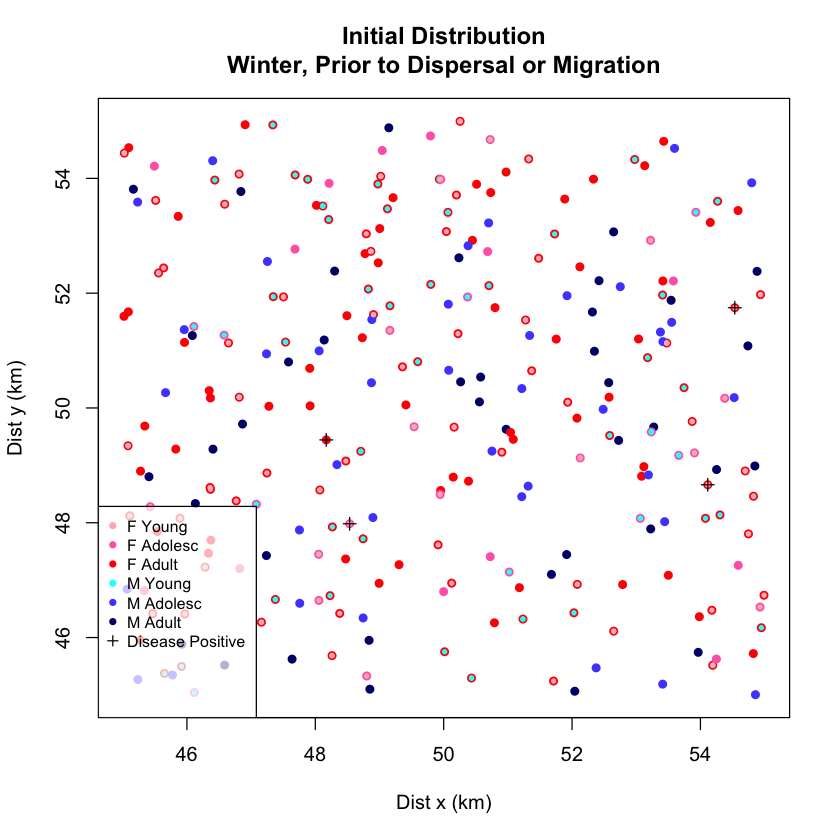

In [8]:
# Apply
animalPlot(xWinter, 
           yWinter, 
           xlim=range(xWinter), 
           ylim=range(yWinter),
           main=paste('Initial Distribution', 
                      'Winter, Prior to Dispersal or Migration', 
                      sep='\n'))

deer distance
1 A    143     
2 B     93     
3 C     97     
4 D     54     
5 E     61     
6 F     59

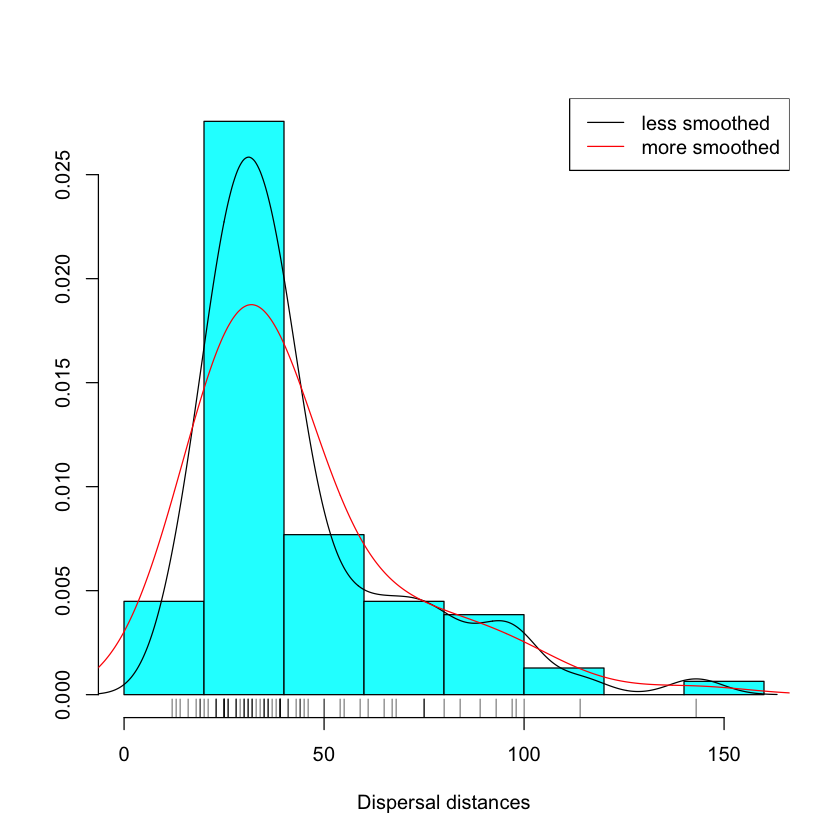

In [9]:
# Determine Dispersal Data
deerDist = read.csv(paste(DATA_DIR, 'DeerDistance.csv', sep='/'))
head(deerDist)
# Here I use dispersal distances of Illinois deer based on the deerDist data 
# set.
# For more details:
truehist(deerDist$distance, xlab = 'Dispersal distances')
rug(deerDist$distance)
# Create a density distribution with a kernel estimate
lines(density(deerDist$distance))
# Smoother:
lines(density(deerDist$distance, adjust = 2), col = 2)
legend(
  'topright', lty=1, col=1:2, legend=c('less smoothed', 'more smoothed'))

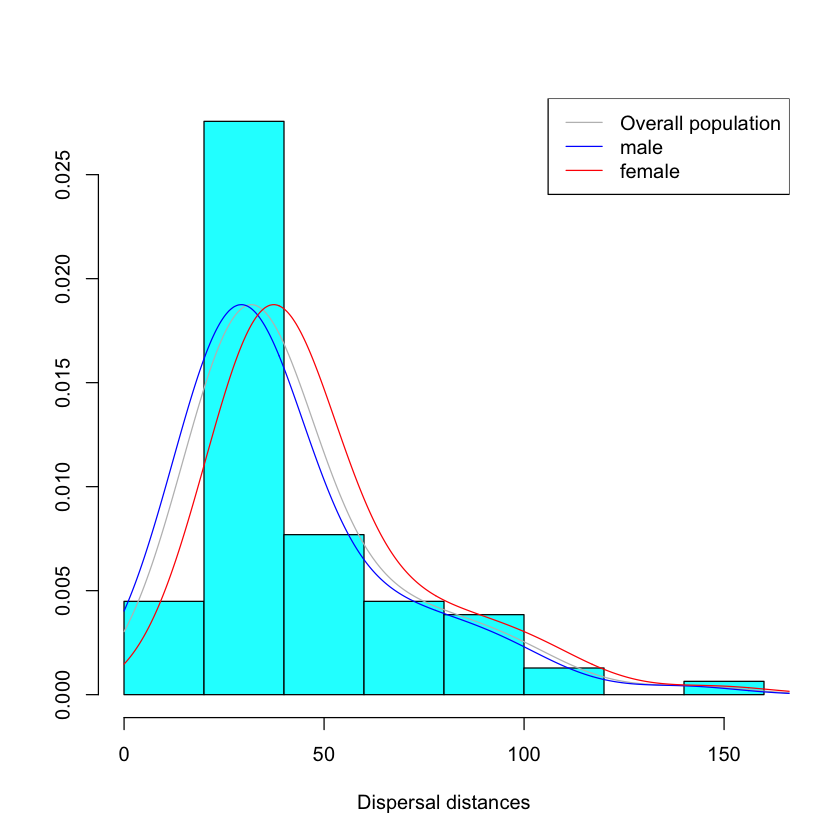

In [10]:
disperseProb = density(deerDist$distance, adjust = 2, from = 0, to = 200)
overallMean = mean(deerDist$distance)
# Those data are for the whole population, but since there are data available
# for both males and females, we can use this to improve the distribution for 
# each sex.
# From Nixon: M mean = 40.9; F mean = 49.0, so adjust for sex:
maleScale = M_MEAN_DISPERSAL_DIST - overallMean	
femaleScale = F_MEAN_DISPERSAL_DIST - overallMean	
maleDisperseProb = density(deerDist$distance + maleScale, adjust = 2,
						   from = 0, to = 200)
femaleDisperseProb = density(deerDist$distance + femaleScale, adjust = 2,
						     from = 0, to = 200)

truehist(deerDist$distance, xlab = 'Dispersal distances')
lines(disperseProb, col = 'grey')
lines(maleDisperseProb, col = 'blue')
lines(femaleDisperseProb, col = 'red')

legend('topright', 
       lty=1, 
       col=c('grey', 'blue', 'red'), 
       legend=c('Overall population', 'male', 'female'))

In [11]:
#===========================================================================#
#																			#
# Function to disperse animals.												#
# Create a probability distribution of dispersal distances,	generate random # 
# direction vectors, display them, and move the animals.					#
# @param dispersed: vector of booleans; where TRUE, animal has already 		#
#					dispersed and is no longer a candidate for dispersal	#
# other params should be self-explanatory									#
# @return: a list including:												#
#		dispersed: boolean; updates the dispersed input parameter			#
#		dispersedThisYear: boolean: TRUE where the animal dispersed this	#
#						   execution										#
#		xSummer, ySummer: x, y coordinates after updated for dispersals		#
#																			#
#===========================================================================#
disperse = function(age, sex, xWinter, yWinter, dispersed) {
	# Disperse animals
	n = length(sex)
	# % of dispersing yrl is given as % of total--convert to % of those not 
	# yet dispersed:
	alreadyDispersedFAdolProp = 
		length(dispersed[dispersed == T & sex == 'F' & age == 'Adol']) / 
		length(sex[sex == 'F' & age == 'Adol']) 

	# If denominator = 0
	if (is.nan(alreadyDispersedFAdolProp))	{ alreadyDispersedFAdolProp = 0 }
	
	FAdolAdjDispersalProb = F_ADOLESC_DISPERSAL_PROB * 
							(1 - alreadyDispersedFAdolProp)

	# Among the non-dispersed animals, randomly select which ones are to 
	# disperse according to the probabilities for their sex and age
	go = (!dispersed) * (
			(sex == 'M' & age == 'Yng') * 
		  	(sample(c(T, F), 
		  		  	size = length(sex == 'M' & age == 'Yng'), 
		  		  	replace = T, 
		  		  	prob = c(M_YOUNG_DISPERSAL_PROB, 
		  		  			 1 - M_YOUNG_DISPERSAL_PROB)
		  	)) + 

		  	(sex == 'F' & age == 'Yng') * 
		  	(sample(c(T, F), 
		  		  	size = length(sex == 'F' & age == 'Yng'),
		   		  	replace = T, 
		   		  	prob = c(F_YOUNG_DISPERSAL_PROB, 
		   		  			 1 - F_YOUNG_DISPERSAL_PROB)
		  	)) + 

		  	(sex == 'F' & age == 'Adol') *
		  	(sample(c(T, F), 
		  			size = length(sex == 'M' & age == 'y'), 
		  			replace = T, 
		  			prob = c(FAdolAdjDispersalProb, 
		  					 1 -FAdolAdjDispersalProb)
		  	)) 
	)
	
	# And randomly assign dispersal distances from the appropriate sex 
	# distribution
	d_dist = go * (!dispersed) * (  
				(sex == 'M' & age == 'Yng') * 
				(sample(maleDisperseProb$x, 
						size = length(sex == 'M' & age == 'Yng'), 
						replace = T, 
						prob = maleDisperseProb$y
				)) +      
				
				(sex == 'F' & age == 'Yng') * 
				(sample(femaleDisperseProb$x, 
						size = length(sex == 'F' & age == 'Yng'), 
						replace = T, 
						prob = femaleDisperseProb$y
				)) +    
				
				(sex == 'F' & age == 'Adol') *
				(sample(femaleDisperseProb$x, 
						size = length(sex == 'F' & age == 'Adol'), 
						replace = T, 
						prob = femaleDisperseProb$y
				))
	)

	# Assign direction, and the corresponding x and y components
	d_heading = runif(n, 0, 2*pi) 
	d_dx = d_dist * sin(d_heading)
	d_dy = d_dist * cos(d_heading)
	xDispersed = xWinter + d_dx
	yDispersed = yWinter + d_dy

	# Set new x, y to xSummer, ySummer
	xSummer = go * xDispersed
	ySummer = go * yDispersed
	xSummer[xSummer == 0] = NA
	ySummer[ySummer == 0] = NA
	
	# Set dispersed and dispersedThisYear to True for new dispersers
	dispersed = as.logical(dispersed + go)
	dispersedThisYear = as.logical(dispersedThisYear + go)
	
	#Return necessary output
	list(dispersed = dispersed, 
		 dispersedThisYear = dispersedThisYear, 
		 xSummer = xSummer, ySummer = ySummer)
}

In [12]:
# Apply the disperse function
disperseData = disperse(age, sex, xWinter, yWinter, dispersed)

# Update the data.frame
detach(Animal.df)
Animal.df$dispersed = disperseData$dispersed
Animal.df$xSummer = disperseData$xSummer
Animal.df$ySummer = disperseData$ySummer
Animal.df$dispersedThisYear = disperseData$dispersedThisYear
attach(Animal.df)

In [13]:
#===========================================================================#
#																			#
# Function to update coordinates for the summer migration					#
# @param: all parameters should be self-explanatory at this point			#
# @return: a list of updated x, y summer coordinates post-migration			#
#																			#
#===========================================================================#
migrateToSummer = function(age, sex, xWinter, yWinter, xSummer, ySummer, 
						   dispersed, dispersedThisYear) {
	# Determine if animal dispersed this year, if so, do not migrate
	# Determine if there are existing xSummer, ySummer, if so return  to 
	# previous; if not add xSummer, ySummer for first-time migrators
	# return xSummer, ySummer
	# For IL, only some Adult and Adolescent Fs migrate
	# Non-dispersing young migrate with mothers

	# Determine if migrator:
	n = length(sex)

	potentialMigratingYng = 
		length(sex[dispersedThisYear == F & age == 'Yng'])

	potentialMigratingAdol = 
		length(sex[dispersedThisYear == F & sex == 'F' & age == 'Adol'])

	potentialMigratingAd = 
		length(sex[dispersedThisYear == F & sex == 'F' & age == 'Ad'])

	# Determine which adolesc and ads will migrate:
	# i.e., dispersedThisYear == F & sex == F & (age == adol | ad)
	goAdolAd = (dispersedThisYear == F) * (sex == 'F') * (
		( (age == 'Ad') * 
		   sample(
		   	   c(1, 0), 
		   	   size = n, replace = T, 
		   	   prob = c(F_ADULT_MIGRATE_PROP, 1 - F_ADULT_MIGRATE_PROP)
		   )
		) + 

		( (age == 'Adol') * 
		   sample(
		   	   c(1, 0), 
		   	   size = n, replace = T, 
		   	   prob = c(F_ADOLESC_MIGRATE_PROP, 1 - F_ADOLESC_MIGRATE_PROP)
		   )
		)
	)
	
	# Determine which yng will migrate:
	# i.e., dispersedThisYear == F & age == 'yng'
	# (Don't need to determine if mother migrates; simply set summer 
	# coordinates same as mother's regardless)
	goYng = (dispersedThisYear == F) * (age == 'Yng')
	
	# Determine migration distances for adolesc and adult migrators from 
	# distribution with empirical mean and sd (different for ad and adol) 
	# NOTE: *** Dispersal distances had a clearly skewed distribution, and it
	# is likely that the same is true for migration distances, but in the 
	# absence of data, I simplify here ***
	m_dist = goAdolAd * ( 
		( (age == 'Adol') * 
		  rnorm(	
		  	  n, 
		  	  mean = F_ADOLESC_MIGRATE_MEAN, 
		  	  sd = F_ADOLESC_MIGRATE_SD
		  )
		) +
		   
		( (age == 'Ad') * 
		  rnorm(n, mean = F_ADULT_MIGRATE_MEAN, sd = F_ADULT_MIGRATE_SD))
	)

	# Randomly generated directions for migrations, and find corresponding 
	# x, y components
	m_heading = runif(n, 0, 2*pi)
	m_dx = m_dist * sin(m_heading)
	m_dy = m_dist * cos(m_heading)
	xSummer[goAdolAd == 1] = xWinter[goAdolAd == 1] + m_dx[goAdolAd == 1]
	ySummer[goAdolAd == 1] = yWinter[goAdolAd == 1] + m_dy[goAdolAd == 1]
	
	# For fawns, set xy = mother's
	xSummer[goYng == 1] = xSummer[mother[goYng == 1]] 
	ySummer[goYng == 1] = ySummer[mother[goYng == 1]]
	
		
	# For yrl_M, ad_M and non-migratory yrl_F and ad_F, set Summer == Winter
	xSummer[is.na(xSummer)] = xWinter[is.na(xSummer)]
	ySummer[is.na(ySummer)] = yWinter[is.na(ySummer)]
	
	# Return necessary output
	list(xSummer = xSummer, ySummer = ySummer)
}

In [14]:
# Determine post-summer-migration coordinates
summerMigrationData = migrateToSummer(
    age, sex, xWinter, yWinter, xSummer, ySummer, dispersed, 
    dispersedThisYear)
detach(Animal.df)
Animal.df$xSummer = summerMigrationData$xSummer
Animal.df$ySummer = summerMigrationData$ySummer
attach(Animal.df)
rm(summerMigrationData)

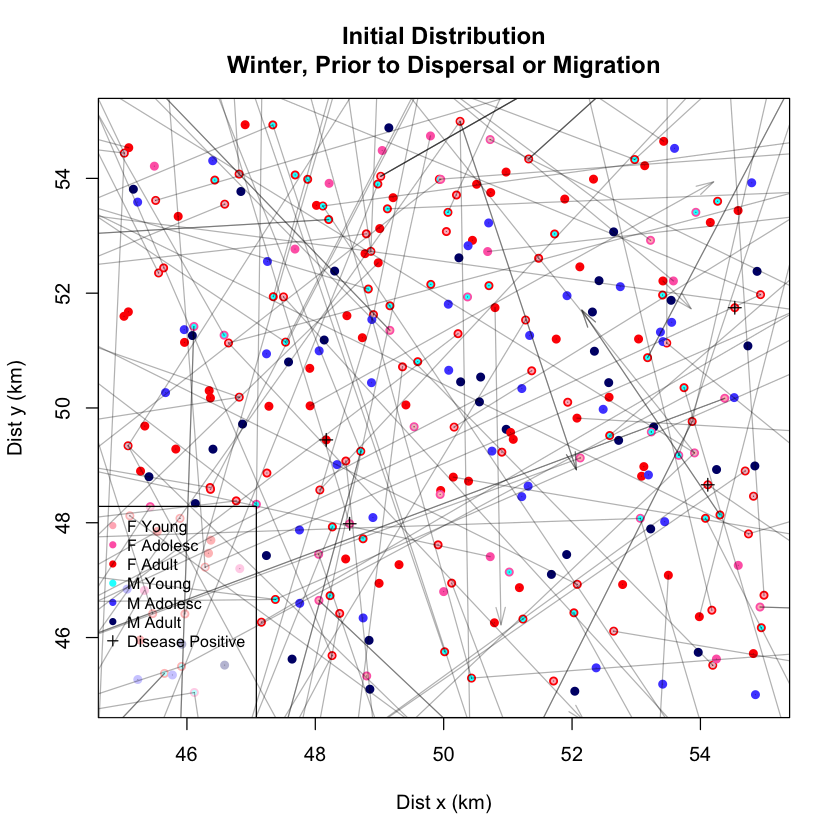

In [15]:
# Replot Distribution
animalPlot(xWinter, yWinter, xlim = range(xWinter), ylim = range(yWinter),
		   main=paste('Initial Distribution', 
                      'Winter, Prior to Dispersal or Migration',
                      sep='\n'))
# Plot dispersal or migration vector
options(warn=-1)# supress warnings about 0-length arrows
arrows(xWinter, yWinter, xSummer, ySummer, angle = 15, length = 0.15,
       col = rgb(0, 0, 0, 0.3))

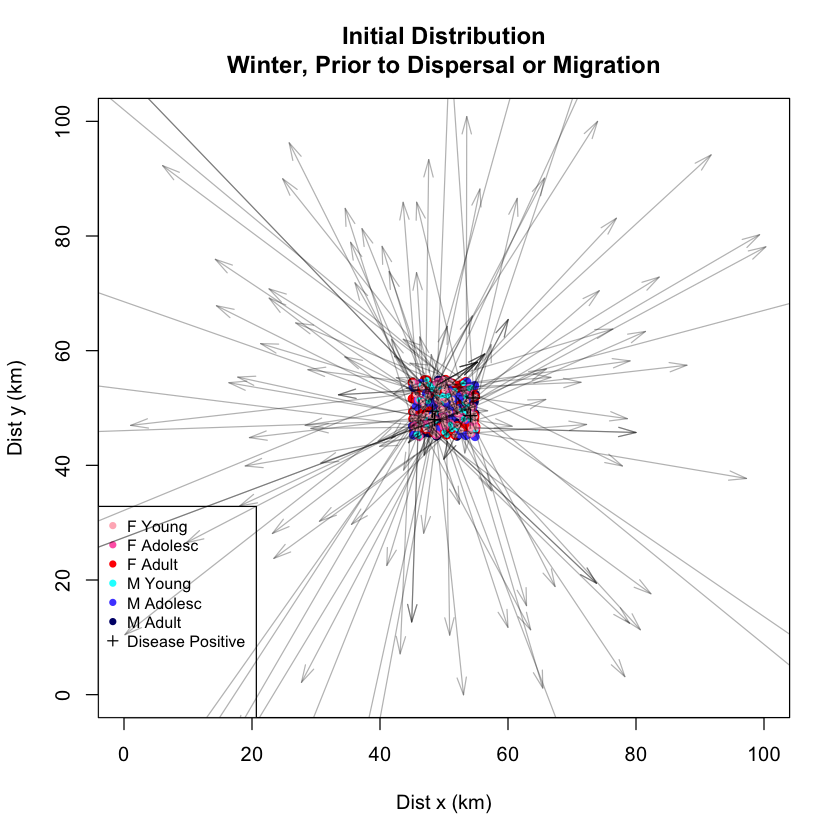

In [16]:
# Zoom out and replot
animalPlot(xWinter, yWinter, 
		   main = paste('Initial Distribution', 
		   				'Winter, Prior to Dispersal or Migration', 
		   				sep = '\n'))

# Plot dispersal or migration vector
arrows(xWinter, yWinter, xSummer, ySummer, angle = 15, length = 0.15, 
col = rgb(0, 0, 0, 0.3))
options(warn=0) # turn warnings back on

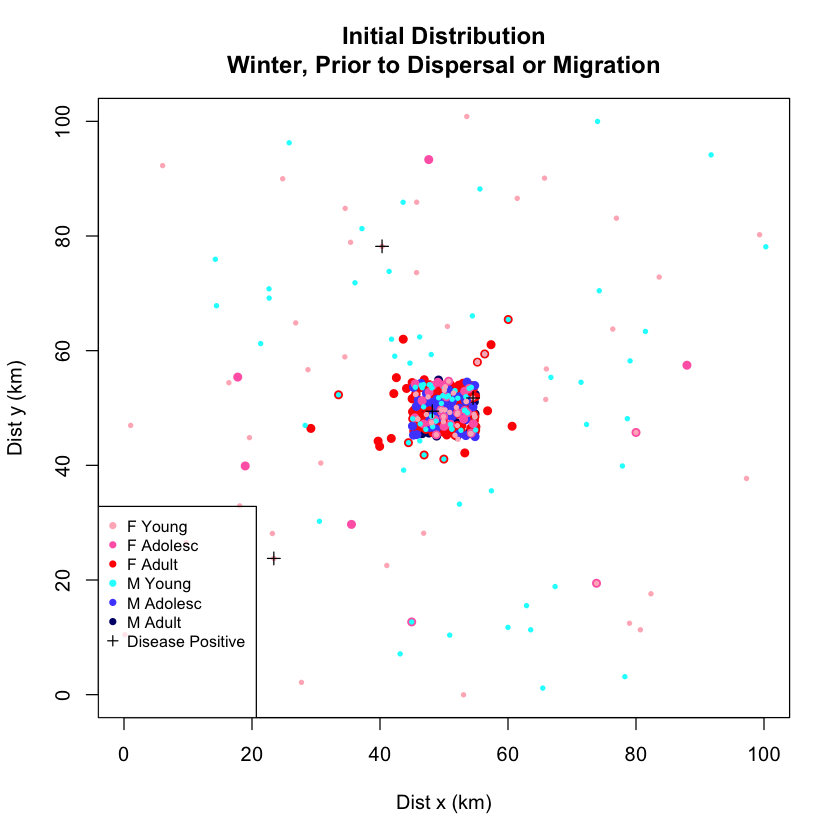

In [17]:
# Plot post-dispersal/summerMigration coordinates
animalPlot(xSummer, ySummer, 
		   main = paste('Initial Distribution', 
		   				'Winter, Prior to Dispersal or Migration', 
                        sep = '\n'))

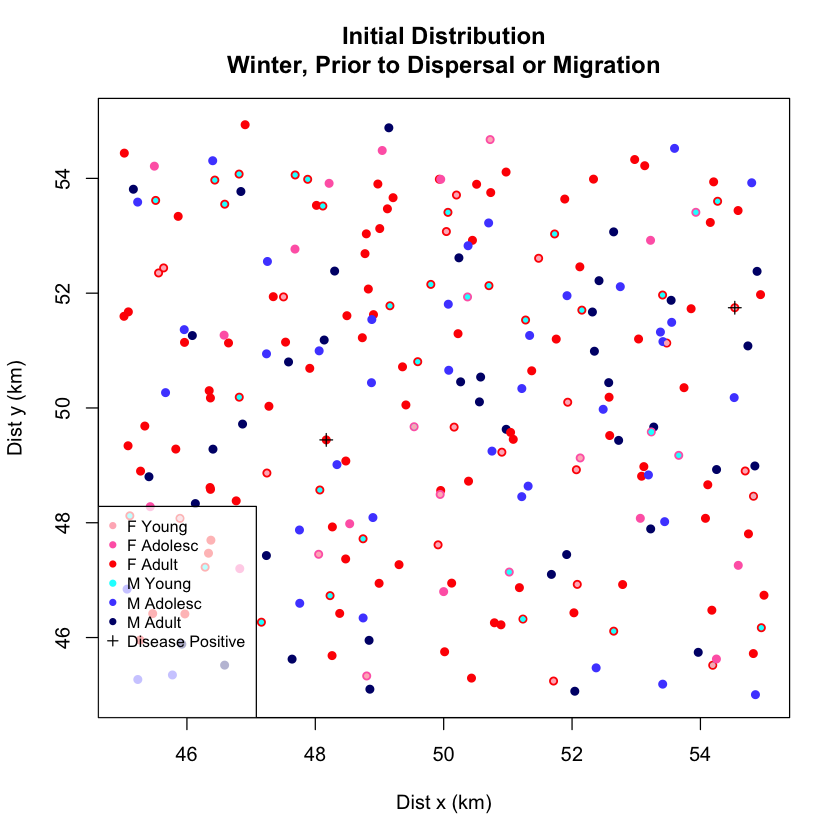

In [18]:
# Zoom back in to show homeranges...
animalPlot(xSummer, ySummer,
		   main = paste('Initial Distribution', 
		   				'Winter, Prior to Dispersal or Migration', 
		   				sep = '\n'),
		   xlim = range(xWinter), ylim = range(yWinter))

In [19]:
# Step 4: Disease Transmission I

#===========================================================================#
#																			#
# Calculate Range Radii														#
# Randomly generates radii for each animal's home range according to 		#
# constant parameters specified at set-up.  The code here simplifies, and 	#
# only uses a single range, but provides seasonal variablity which could	#
# be updated to make more elaborate models.									#
# @params: should be self-explanatory										#
# @return a list of vectors, each indicating radii of home ranges under		#
#	different seasonal conditions											#
#																			#
#===========================================================================#
calculateRanges = function(sex, age) {

	calculateRadii = function(sx, ag, n, mn, std) {
		area1 = (sex == sx) * (age == ag[1]) * rnorm(n, mn[1], std[1]) 
		area2 = (sex == sx) * (age == ag[2]) * rnorm(n, mn[2], std[2]) 
		areaSum = area1 + area2
		areaSum[areaSum < 0] = 0
		
		# Determine radii
		rad = sqrt(areaSum / pi)
		return (rad)
	}

	n = length(sex)

	# Males	
	postrutRM = calculateRadii(
		'M', c('Adol', 'Ad'), n, 
		c(M_ADOLESC_POSTRUT_MEAN, M_ADULT_POSTRUT_MEAN),
		c(M_ADOLESC_POSTRUT_SD, M_ADULT_POSTRUT_SD)
	)
	
	prerutRM = calculateRadii(
		'M', c('Adol', 'Ad'), n,
		c(M_ADOLESC_PRERUT_MEAN, M_ADULT_PRERUT_MEAN),
		c(M_ADOLESC_PRERUT_SD, M_ADULT_PRERUT_SD)
	)

	rutRM = calculateRadii(
		'M', c('Adol', 'Ad'), n,
		c(M_ADOLESC_RUT_MEAN, M_ADULT_RUT_MEAN),
		c(M_ADOLESC_RUT_SD, M_ADULT_RUT_SD)
	)

	# Females
	prebreedingRF = calculateRadii(
		'F', c('Adol', 'Ad'), n,
		rep(F_ADOLESC_ADULT_PREBREEDING_MEAN, 2),
		rep(F_ADOLESC_ADULT_PREBREEDING_SD, 2)
	)
	
	postbreedingRF = calculateRadii(
		'F', c('Adol', 'Ad'), n,
		rep(F_ADOLESC_ADULT_POSTBREEDING_MEAN, 2),
		rep(F_ADOLESC_ADULT_POSTBREEDING_SD, 2)
	)

	parturitionRF = calculateRadii(
		'F', c('Adol', 'Ad'), n,
		rep(F_ADOLESC_ADULT_PARTURITION_MEAN, 2),
		rep(F_ADOLESC_ADULT_PARTURITION_SD, 2)
	)

	#Return:
	return (list(
		postrutRM = postrutRM, 
		prerutRM = prerutRM, 
		rutRM = rutRM, 
		prebreedingRF = prebreedingRF, 
		postbreedingRF = postbreedingRF, 
		parturitionRF = parturitionRF
	))
} 

In [20]:
# Apply
rangeData = calculateRanges(sex, age)
detach(Animal.df)
Animal.df$postrutRM = rangeData$postrutRM
Animal.df$prerutRM = rangeData$prerutRM
Animal.df$rutRM = rangeData$rutRM
Animal.df$prebreedingRF = rangeData$prebreedingRF
Animal.df$postbreedingRF = rangeData$postbreedingRF
Animal.df$parturitionRF = rangeData$parturitionRF
# In this demo, to simplify, we model ranges as the largest of any of the
# seasonal ranges
Animal.df$maxRadius = pmax(
	Animal.df$postrutRM, Animal.df$prerutRM, Animal.df$rutRM, 
	Animal.df$prebreedingRF, Animal.df$postbreedingRF, 
	Animal.df$parturitionRF
)
attach(Animal.df)
MAX_RANGE = max(maxRadius)

In [21]:
#=======================================================================#
#																		#
# Helper function to draw a circle										#
# Draw a circle with radius r, centered at (x, y) with specified color	#
#																		#
#=======================================================================#
circlePlot = function(x, y, r, color) {
	theta = seq(0, 2 * pi, pi / 50)
	yv = r * sin(theta)
	xv = r * cos(theta)
	lines(x + xv, y + yv, col = color)
}

In [22]:
#===============================#
# 								#
# Plot ranges of all animals	#
#								#
#===============================#
rangePlot = function(x, y) {
	for (i in 1:length(sex)) {
		circlePlot(x[i], y[i], maxRadius[i], 
				   col = colorMatrix[sex[i], age[i]])
	}

	addLegend()
}

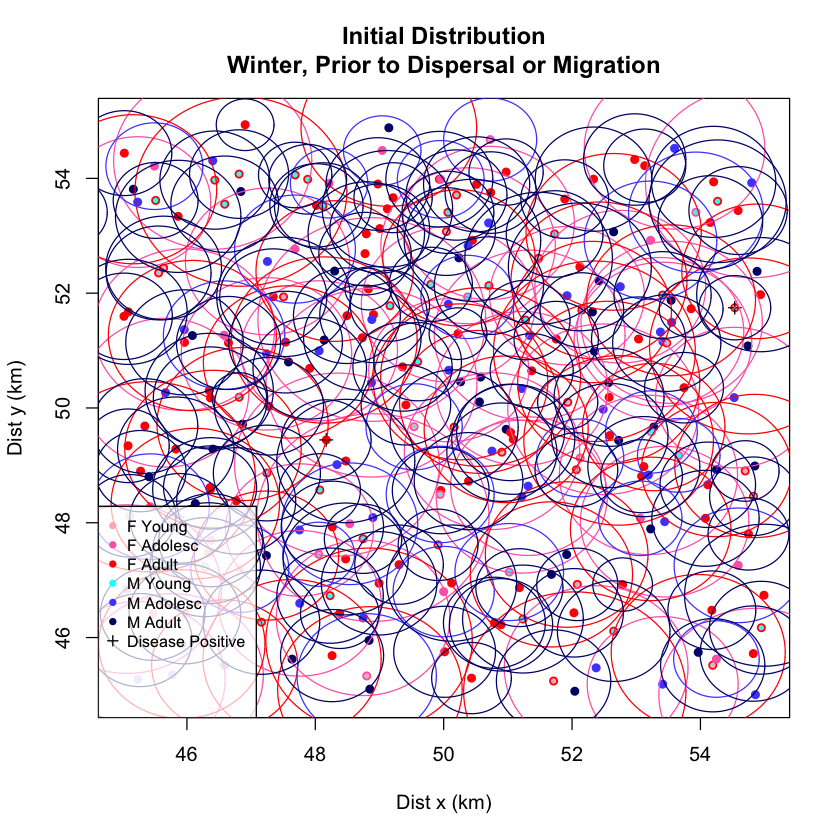

In [23]:
# Apply
animalPlot(xSummer, ySummer,
		   main = paste('Initial Distribution', 
		   				'Winter, Prior to Dispersal or Migration', 
		   				sep = '\n'),
		   xlim = range(xWinter), ylim = range(yWinter))
rangePlot(xSummer, ySummer)

In [24]:
# Infect Soil/Environment
# Determine x, y coordinates of infected animals
infX = xSummer[diseaseStatus == 'pos']
infY = ySummer[diseaseStatus == 'pos']

In [25]:
#===========================================================================#
#																			#
# Create a matrix to use for heat maps of infectious soil; matrix 			#
# represents MAP_UNIT x MAP_UNIT km squares of the map to keep track		#
# @params mapX, mapY: dimensions of matrix/area to be tracked				#
# @param mapUnit: used to determine the resolution (i.e., grid cell size)	#
# @params infX, infY: as above, vectors of x and y coordinates of infected	#
#	                  animals												#
# @params soilMatrix.M: an existing soilMatrix to be updated, if NULL will	#
#              			be initialized 										#
# @return M: a matrix representation of the infectious load at each grid 	#
#			 cell, where each unit value indicates infectious content from 	#
#			 1 animal at one time step										#
#																			#
#===========================================================================#
soilMatrix = function(infX, infY, mapX = MAP_X, mapY = MAP_Y, 
					  mapUnit = MAP_UNIT, soilMatrix.M = NULL) {
	M = matrix(data = 0, 
			   nrow = round(diff(mapX) / mapUnit, 0),
			   ncol = round(diff(mapY) / mapUnit, 0))
			   
	infX = round(infX, 0) + 1 # assigned to map indices so must be ints ≥1
	infY = round(infY, 0) + 1
	outXHigh = which(infX > mapX[2])	# check if off map
	outXLow = which(infX < mapX[1])
	outX = c(outXHigh, outXLow)
	outYHigh = which(infY > mapX[2])
	outYLow = which(infY < mapX[1])
	outY = c(outYHigh, outYLow)
	outs = unique(c(outX, outY))
	
	# remove if off map
	if (length(outs) > 0) {
		infX = infX[-outs]	
		infY = infY[-outs]
	}
	
	for(i in 1:length(infX)) {
		M[infX[i], infY[i]] = M[infX[i], infY[i]] + 1
	} 

	if(!is.null(soilMatrix.M)) {
		M = M + soilMatrix.M
	}

	return (M)
} 

In [26]:
soil.M = soilMatrix(infX = infX, infY = infY)
rm(infX, infY)

In [27]:
#===========================================================================#
#																			#
# Plot environmental infection as a heat map								#
# Distinct colors to show up on heatmap = max infectious load, set to at 	#
# least 12																	#
# @param M: the soilMatrix to be represented								#
#																			#
#===========================================================================#
soilPlot = function(M = soil.M) {
	HEAT_COLORS = max(round(max(soil.M)) + 1, 12)
	par(mar = c(4, 4, 1, 1))
	image(
		M, col = rev(heat.colors(HEAT_COLORS)), 
		xaxt = 'n', yaxt = 'n', xlab = 'km', ylab = 'km', 
	)
	axis(1, at = seq(0, 1, length.out = 11), 
	 	 labels = round(seq(MAP_X[1], MAP_X[2], length.out = 11)))
	axis(2, at = seq(0, 1, length.out = 11), 
	 	 labels = round(seq(MAP_Y[1], MAP_Y[2], length.out = 11)))
	
	legend('topright', legend = paste('Max Load =', round(max(M), 2)), 
		   col = rgb(1, 1, 1, 0.7))
	# reset margins
	par(mar = c(5, 4, 4, 2) + 0.1)
}

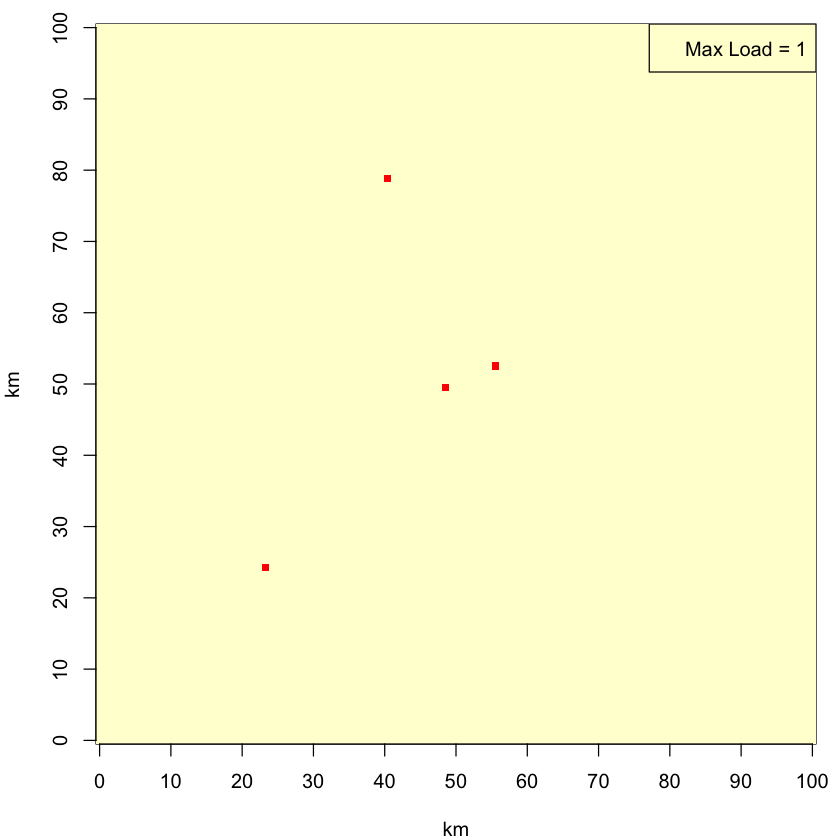

In [28]:
soilPlot()

In [29]:
#===========================================================================#
#																			#
# Infect other animals: Animal-to-animal									#
# Determines which animals are to be newly infected from contact with 		#
# nearby infected animals													#
#																			#
# @param disease.status: a vector with values 'pos' or 'neg'				# 
# other params should be self-explanatory									#
# @return newPos: a factor vector with levels 'pos' and 'neg' to update		#
# 				  disease status											#
#																			#
#===========================================================================#
animalInfect = function(disease.status, x, y, homerange, 
						contactProb = CONTACT_PROB, infectProb = INFECT_PROB) {
	posDeer = which(disease.status == 'pos')
	
	if (length(posDeer > 0)) {
		# for all deer Calculate xs and ys that delimit range as a square
		atRisk = matrix(data = 0, nrow = length(posDeer), 
						ncol = length(disease.status))
		rownames(atRisk) = posDeer
	
		for (i in 1:length(posDeer)) {
			for (j in 1:length(disease.status)) {
				ijDist = sqrt((x[posDeer[i]] - x[j])^2 + 
							  (y[posDeer[i]] - y[j])^2)
				reachableDist = homerange[posDeer[i]] + homerange[j]

				if (reachableDist >= ijDist) {
					atRisk[i,j] = atRisk[i,j] + 1
				}
			}
		}	

		contactMadeWithPos = atRisk * contactProb
		newPos = (contactMadeWithPos) * 
				  # in the sample(), 1 = contract disease, 0 = not
				  sample(c(0, 1), 
				 		 size = length(disease.status), 
				 		 replace = T, 
				 		 prob = c(1 - infectProb, infectProb)) 
		newPos = 1* (colSums(newPos) > 0)
		newPos = factor(newPos, levels = c(0, 1), labels = c('neg', 'pos'))
	} else {
		newPos = disease.status
	}

	return (newPos)
}

In [30]:
newPos = animalInfect(disease.status = diseaseStatus, x = xSummer, 
					  y = ySummer, homerange = maxRadius)
detach(Animal.df)
Animal.df$diseaseStatus[Animal.df$diseaseStatus == 'neg'] = 
	newPos[Animal.df$diseaseStatus == 'neg']

# NOTE: The is.na() condition makes sure that if deer is already positive, 
# yearsInfected is not reset back to 0
Animal.df$yearsInfected[
	Animal.df$diseaseStatus == 'pos' & is.na(Animal.df$yearsInfected)
] = 0
attach(Animal.df)
rm(newPos)

In [31]:
#===========================================================================#
#																			#
# Infect Soil/environment-to-animal											#
# @param scalar: Based on the soil load at each animals's x, y coordinates, #
#  				 animals become infected with 								#
#				 probability = (scalar*load) / (scalar*load + 1); 			#
#				 Thus, the scalar has the effect that when 					#
#				 load = 1 / scalar, prob = 0.5, 							#
#				 thus for load = 1 and scalar = 1, p = 0.5, 				#
#				 increasing scalar to 2 means at load 0.5, p = 0.5 			#
#				 and conversely, decreasing scalar to 0.5 means that load	#
#				 must be 2 for p to be = 0.5								#
#																			#
# To keep the code simple, an animal is only considered at risk if its x, y #
# lies within an infected region, (e.g., if the center of its home range, 	#
# and not if *any* of its range is within an infected region)				#
#																			#
# @return: a list of vectors infected updating the infected status, and		#
#		   yearsInfected to update yearsInfected							#
#===========================================================================#
soilInfect = function(soil.M, x, y, diseaseStatus, yearsInfected, 
					  scalar = SCALAR) {
	soil.M.dim = dim(soil.M)[1]
	infectProbability.M = (scalar*soil.M) / (scalar*soil.M + 1)
	x = floor(x) + 1	# e.g., an x of 0.2 -> 0 + 1 -> 1 = first row of M
	y = floor(y) + 1
	x[x <= 0] = NA
	x[x > soil.M.dim] = NA
	y[y <= 0] = NA
	y[y > soil.M.dim] = NA

	# initialize; will be a vector of probabilities of infection
	infected = rep('neg', length(x))	

	for (i in 1:length(x)) {
		if (infectProbability.M[x[i], y[i]] > 0 & 
			(!is.na(infectProbability.M[x[i], y[i]]))) {
			infected[i] = sample(
				c('pos', 'neg'), 
				size = 1, replace = F,
				prob = c(infectProbability.M[x[i], y[i]], 
						 1 - infectProbability.M[x[i], y[i]])
			)
		}
	}

	infected[diseaseStatus == 'pos'] = 'pos'
	yearsInfected[is.na(yearsInfected) & infected == 'pos'] = 0
	list(infected = infected, yearsInfected = yearsInfected)
}

In [32]:
soilInfectData = soilInfect(
    soil.M = soil.M, x = xSummer, y = ySummer, 
    diseaseStatus = diseaseStatus, yearsInfected = yearsInfected)
detach(Animal.df)
Animal.df$diseaseStatus = soilInfectData$infected
Animal.df$yearsInfected = soilInfectData$yearsInfected
attach(Animal.df)

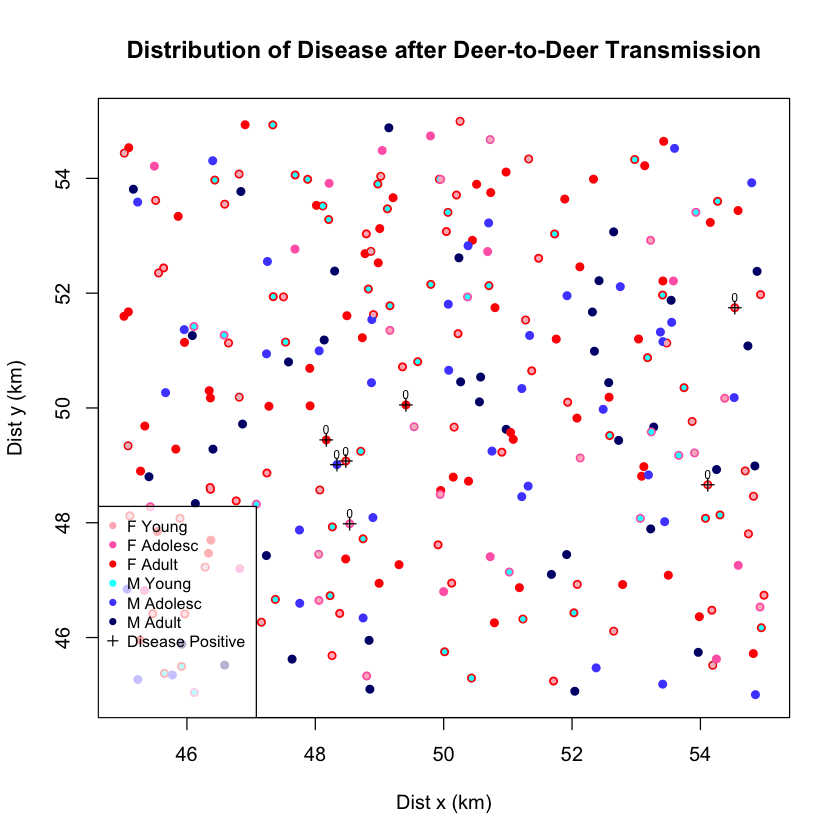

In [33]:
# Plot Showing newly infected animals and time infected
animalPlot(xWinter, yWinter, yrsInfected = T, 
		   main = 'Distribution of Disease after Deer-to-Deer Transmission',
xlim = range(xWinter), ylim = range(yWinter))

In [34]:
# Step 5: Migrate Back
#===========================================================================#
#																			#
# Migrate to Winter Grounds													#
# This function migrates deer from summer grounds back to winter grounds	#
# Each year's **dispersers** WILL NOT return to previous winter grounds but #
# to new ones.  All others return to previous.								#
#																			#
# @params: self-explanatory													#
# @return: a list including vectors xWinter and yWinter to update winter	#
#		   coordinates														#
#																			#
#===========================================================================#
migrateToWinter = function(age, sex, xWinter, yWinter, xSummer, ySummer, 
						   dispersedThisYear) {
	n = length(sex)
	goFDispersers = (dispersedThisYear == T) * 
		(sex == 'F' & (age == 'Adol' | age == 'Yng')) * 
		(sample(c(1, 0), size = n, replace = T, 
				prob = c(F_ADOLESC_MIGRATE_PROP, 
						 1 - F_ADOLESC_MIGRATE_PROP)))
				
	stayFDispersers = (dispersedThisYear == T) * (goFDispersers == F)
	# get migration distances
	m_dist = goFDispersers * 
		rnorm(n, mean = F_ADOLESC_MIGRATE_MEAN, sd = F_ADOLESC_MIGRATE_SD)
	# get headings and x, y components
	m_heading = runif(n, 0, 2 * pi)
	m_dx = m_dist * sin(m_heading)
	m_dy = m_dist * cos(m_heading)

	xWinter[goFDispersers == 1] = xSummer[goFDispersers == 1] +
		m_dx[goFDispersers==1]
	yWinter[goFDispersers == 1] = ySummer[goFDispersers == 1] + 
		m_dy[goFDispersers == 1]
	xWinter[stayFDispersers == 1] = xSummer[stayFDispersers == 1]
	yWinter[stayFDispersers == 1] = ySummer[stayFDispersers == 1]

	list(xWinter = xWinter, yWinter = yWinter)
} 

In [35]:
# Apply
winterMigrationData = migrateToWinter(
	age = age, sex = sex, xWinter = xWinter, yWinter=yWinter, 
	xSummer = xSummer, ySummer = ySummer, 
	dispersedThisYear = dispersedThisYear
)

detach(Animal.df)
Animal.df$xWinter = winterMigrationData$xWinter
Animal.df$yWinter = winterMigrationData$yWinter
attach(Animal.df)
rm(winterMigrationData)

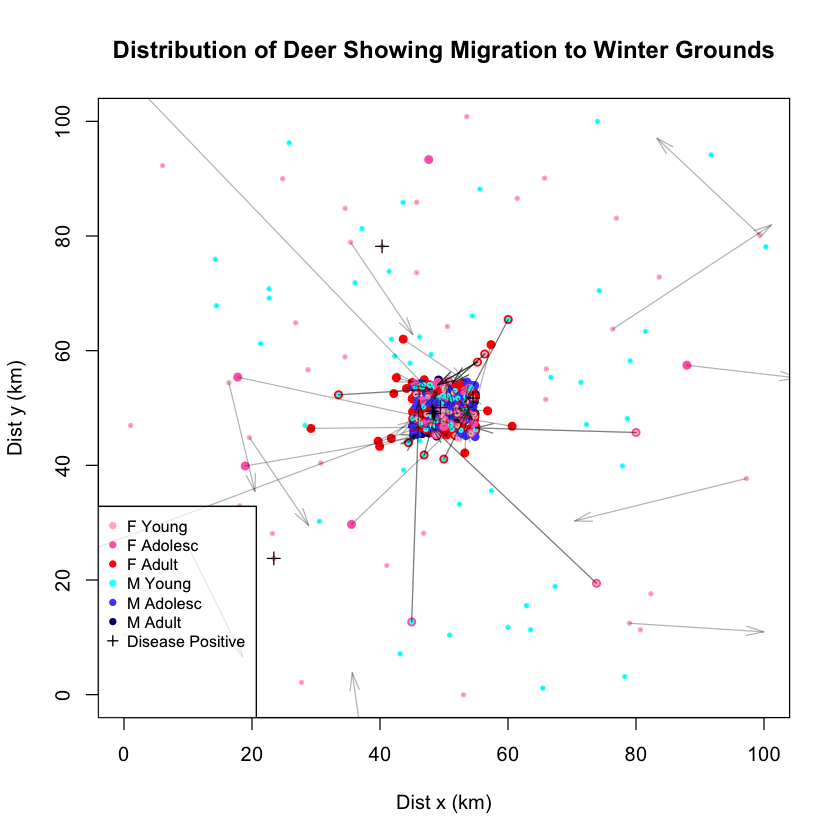

In [36]:
# Plot pre-Winter Migration:
animalPlot(xSummer, ySummer,
		   main = paste('Distribution of Deer Showing', 
		   				'Migration to Winter Grounds'))

# Winter migration vectors
options(warn=-1)
arrows(xSummer, ySummer, xWinter, yWinter, angle = 15, length = 0.15, 
	   col = rgb(0, 0, 0, 0.3))
addLegend()
options(warn=0)

In [37]:
# Step 6. Disease Infection II
# Infect Soil
infX = xWinter[diseaseStatus == 'pos']
infY = yWinter[diseaseStatus == 'pos']
soil.M = soilMatrix(infX = infX, infY = infY, soilMatrix.M = soil.M)
rm(infX, infY)

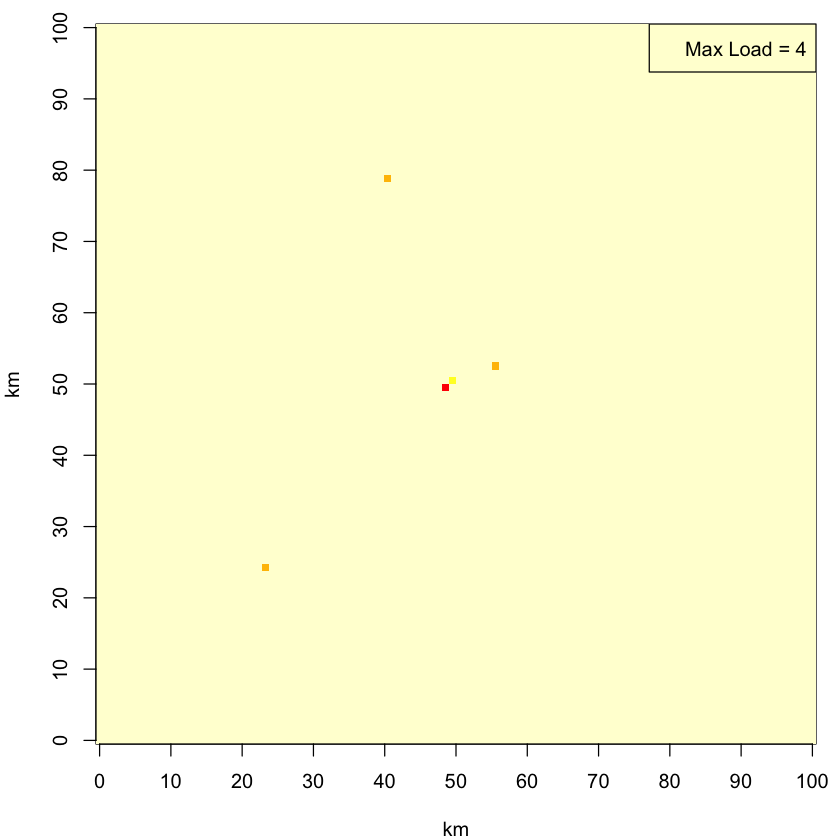

In [38]:
# Plot
soilPlot()

In [39]:
# Infect other deer
# Animal-to-animal
newPos = animalInfect(disease.status = diseaseStatus, x = xWinter, 
					  y = yWinter, homerange = maxRadius)
detach(Animal.df)
Animal.df$diseaseStatus = newPos
Animal.df$yearsInfected[
	Animal.df$diseaseStatus == 'pos' & is.na(Animal.df$yearsInfected)] = 0
attach(Animal.df)
rm(newPos)

In [40]:
soilInfectData = soilInfect(soil.M = soil.M, x = xWinter, y = yWinter, 
							diseaseStatus = diseaseStatus, 
							yearsInfected = yearsInfected)
detach(Animal.df)
Animal.df$diseaseStatus = soilInfectData$infected
Animal.df$yearsInfected = soilInfectData$yearsInfected
attach(Animal.df)

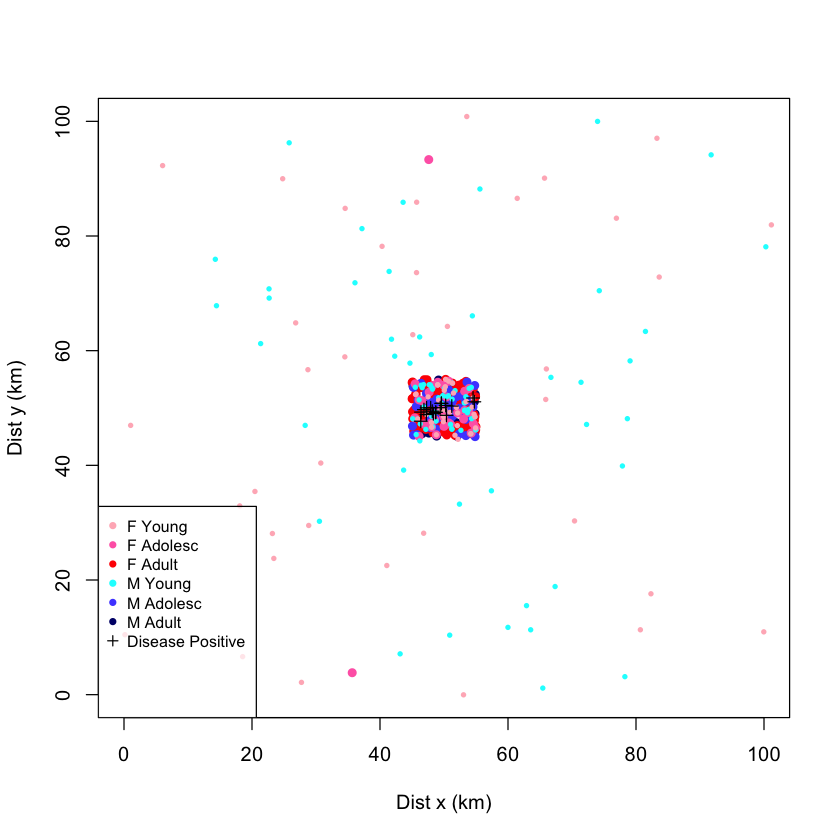

In [41]:
# Plot 
animalPlot(xWinter, yWinter)

In [42]:
# Step 7: Mortality

#===========================================================================#
#																			#
# This function takes deer age and sex data and randomly kills off 			#
# proportions of each according to the specified mortality rates.			#
# @return totalDeaths: a vector with values 'alive' or 'dead' to update the	#
# 					   vitality field in Animal.df							#
#																			#
#===========================================================================#
die = function(age, sex, yearsInfected, mYngMort = M_YOUNG_MORT, 
			   mAdolMort = M_ADOLESC_MORT, mAdMort = M_ADULT_MORT, 
			   fYngMort = F_YOUNG_MORT, fAdolMort = F_ADOLESC_MORT, 
			   fAdMort = F_ADULT_MORT, maxLifeExp = MAX_LIFE_EXPECTANCY) {
	n = length(age)
	
	kill = function(sx, ag, mort) {
		deaths = (sex == sx & age == ag) * 
			sample(c(0, 1), size = n, replace = T,
				   prob = c(1 - mort, mort))
	}
	
	mYngDeaths = kill('M', 'Yng', mYngMort)	
	mAdolDeaths = kill('M', 'Adol', mAdolMort)	
	mAdDeaths = kill('M', 'Ad', mAdMort)	
	fYngDeaths = kill('F', 'Yng', fYngMort)	
	fAdolDeaths = kill('F', 'Adol', fAdolMort)	
	fAdDeaths = kill('F', 'Ad', fAdMort)	
	totalDeaths = mYngDeaths + mAdolDeaths + mAdDeaths + fYngDeaths + 
		fAdolDeaths + fAdDeaths
	totalDeaths[yearsInfected > maxLifeExp] = 1
	totalDeaths = factor(totalDeaths, levels = c(0, 1), 
						 labels = c('alive', 'dead'))
	return (totalDeaths)
}

In [43]:
deathData = die(age = age, sex = sex, yearsInfected = yearsInfected)
detach(Animal.df)
Animal.df$vital = deathData
attach(Animal.df)

In [44]:
#===================================#
#									#
# Add deaths to an existing plot	#
#									#
#===================================#
deathPlot = function(...) {
	points(xWinter[vital == 'dead'], yWinter[vital == 'dead'], pch = 16, 
		   col = COLOR_DEAD)
	addLegend(deaths = T)
}

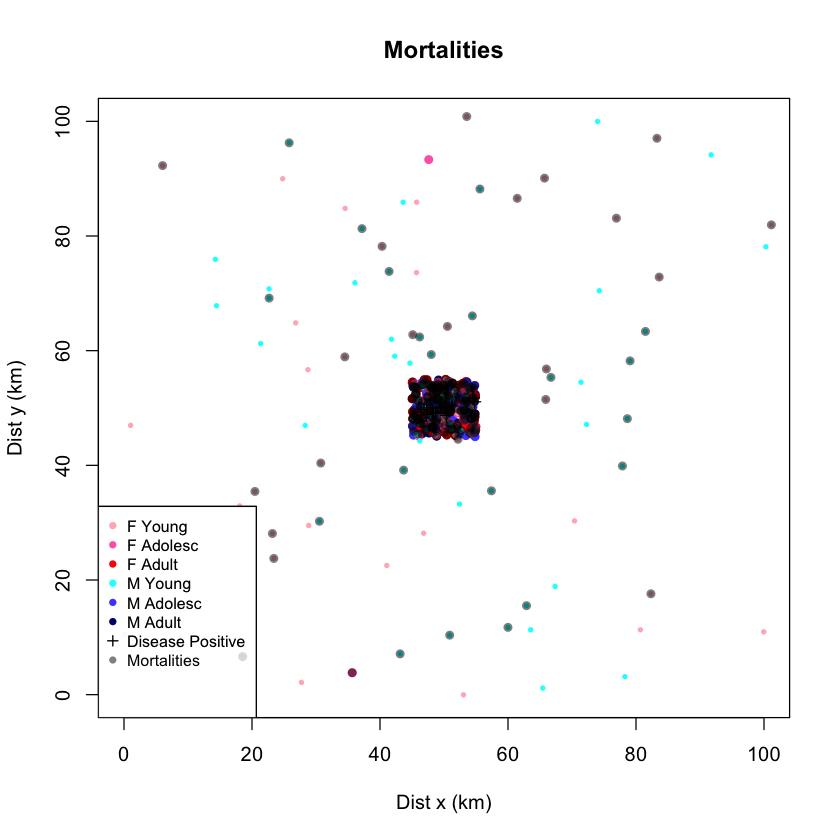

In [45]:
animalPlot(xWinter, yWinter)
deathPlot()
title('Mortalities')

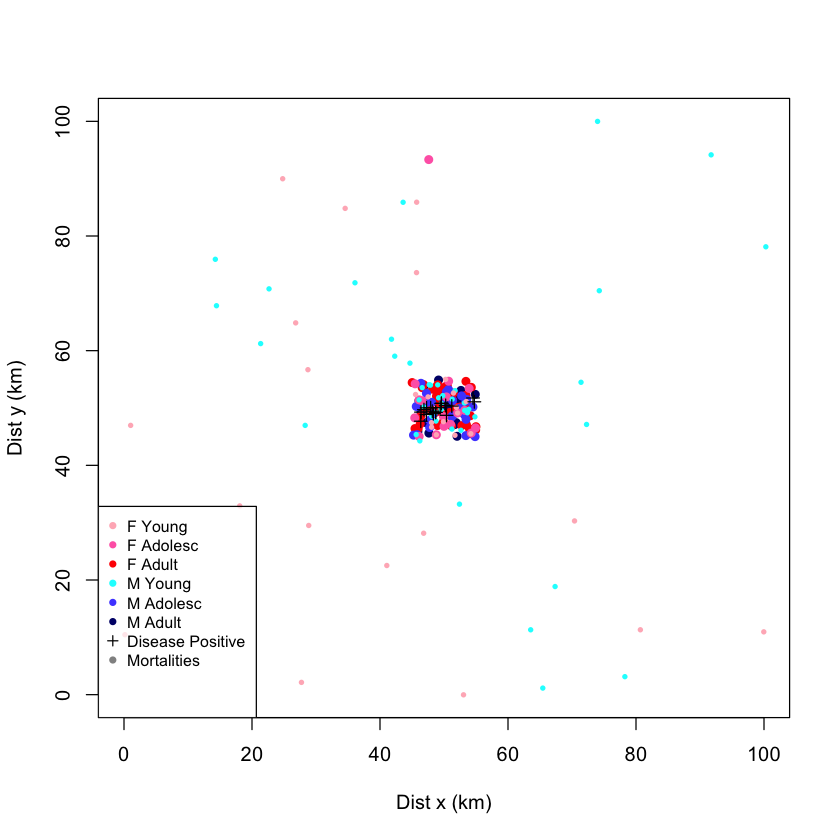

In [46]:
# Plot new distribution
animalPlot(xWinter, yWinter, mort = T)

In [47]:
#===================#
#					#
# Plot subdivisions	#
#					#
#===================#
divPlot = function() {
	nsSubLines = MAP_X[2] / SUBDIVISION
	ewSubLines = MAP_Y[2] / SUBDIVISION

	for(i in 0:(max(nsSubLines, ewSubLines))) {
		abline(h = SUBDIVISION * i)
		abline(v = SUBDIVISION * i)
	}
	
	addLegend()
}

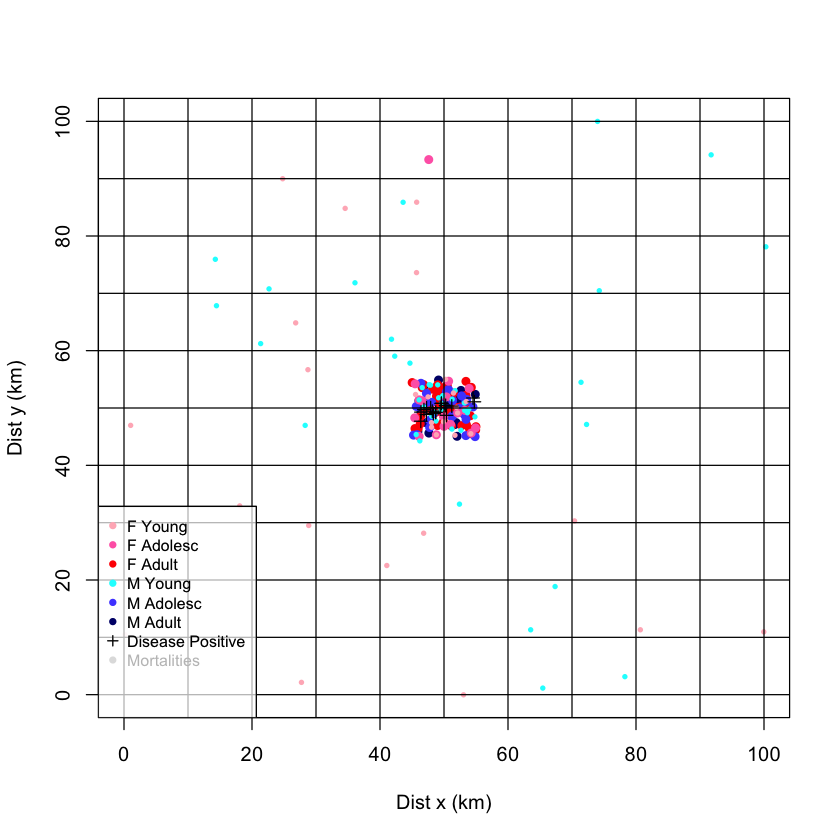

In [48]:
animalPlot(xWinter, yWinter, mort = T)
divPlot()

In [49]:
# Remove Dead Deer
detach(Animal.df)
Animal.df = subset(Animal.df, vital == 'alive')
attach(Animal.df)

In [50]:
# Cap by Capacity at each subdivision
# First assign to subdivisions

#===================================================================#
#																	#
# Takes deer x and y coordinates and assigns to subdivision plot 	#
# coordinates														#
# @params x, y: vectors of x and y coordinates of all animals		#
# @return: a list including vectors xSub and ySub indicating the 	#
#		   subdivision grid indices for all animals					#
#																	#
#===================================================================#			
subAssign = function(x, y, subdivision = SUBDIVISION) {
	xSub = floor(x / subdivision) + 1
	ySub = floor(y / subdivision) + 1
	return (list(xSub = xSub, ySub = ySub))
}

In [51]:
subAssignData = subAssign(xWinter, yWinter)
detach(Animal.df)
Animal.df = cbind(Animal.df, xSub = subAssignData$xSub, 
				  ySub = subAssignData$ySub)
attach(Animal.df)

In [52]:
# Then Cap at K

#===========================================================================#
#																			#
# This function kills off any excess deer beyond capacity if exceeded		#
# @params xSub, ySub: the vectors indicating the cell (subdivision) of each	#
#					  animal												#
# @param vital: vector of "alive" or "dead" values (don't kill dead animals #
#				or count them among the living)								#
# @param id: vector of animal ids											#
# @param K: local capacity limit, defined by MAX_DENSITY in initial 		#
#			constants														#
# @return vital: a vector to update Animal$vital							#
#																			#
#===========================================================================#
kCap = function(xSub, ySub, vital, id, subdivision = SUBDIVISION, 
				K = MAX_DENSITY) {
	localMaxDeer = K * subdivision^2
	cull = c()

	for (i in unique(xSub)) {
		for (j in unique(ySub)) {
			# no of deer in division i, j
			ijCount = length(xSub[xSub == i & ySub == j]) 
			if (ijCount > localMaxDeer) {
				cullNumber = ijCount - localMaxDeer
				cull = sample(id[xSub == i & ySub == j], size = cullNumber)
			}
		}
	}

	vital[id%in%cull] = 'dead'
	return (vital)
}

In [53]:
kCapData = kCap(xSub, ySub, vital, id)
detach(Animal.df)
Animal.df$vital = kCapData
attach(Animal.df)

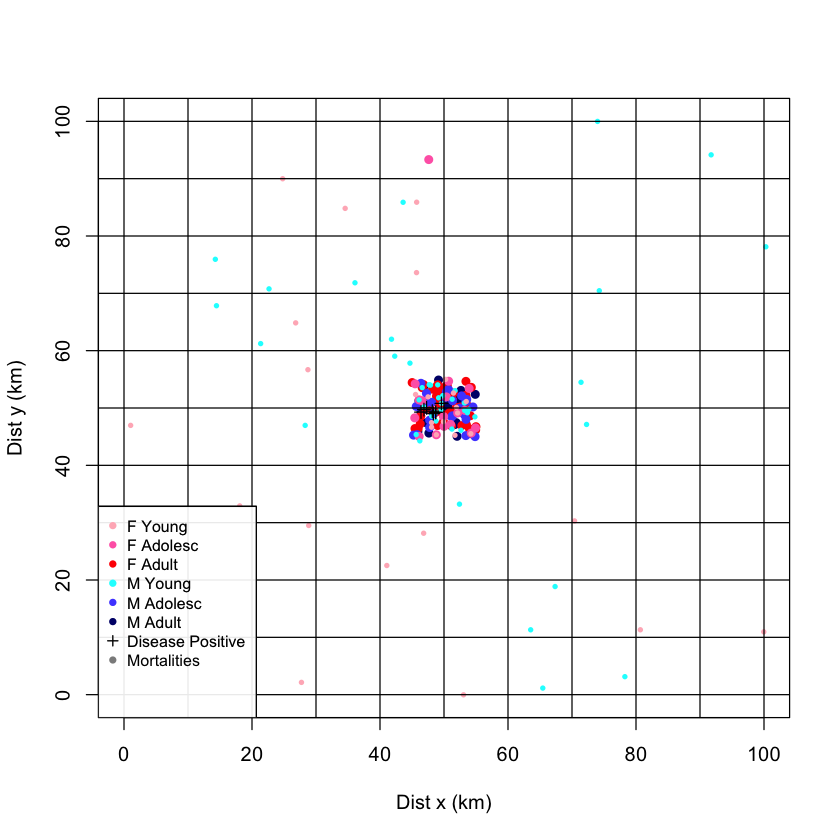

In [54]:
animalPlot(xWinter, yWinter, mort = T)
divPlot()
deathPlot()

# Note: no change here as all subdivisions are below capacity.

In [55]:
#Remove Dead Deer
detach(Animal.df)
Animal.df = subset(Animal.df, vital == 'alive')
attach(Animal.df)

In [56]:
# Step 8: Reproduction

# Reproduce
maxID = max(id) # will need to continue adding new IDs at maxID + 1

In [57]:
#===========================================================================#
#																			#
# Function reproduce() takes existing population of females with known age 	#
# classes, and provides them with offspring according to input 				#
# specifications for the probability of each age class. 					#
# @params x, y: vectors of x, y-coordinates, necessary to ensure that 		#
# 				newborns are assigned to same coordinates as mother.  		#
# @param id: needed for the 'mother' field for newborns. 					#
# @param maxID: the highest existing id number, newborn assignments will 	#
# continue from there. 														#	
# All params should be obvious from above constants and previous functions	#
#																			#
# @return NewBorns: a data.frame of newborns that can be merged with 		#
# Animal.df																	#
#																			#
#===========================================================================#
reproduce = function(
	sex, age, id, maxID, x, y, mBirthProp = M_BIRTH_PROP, 
	fBirthProp = F_BIRTH_PROP, yngPregRate = YOUNG_PREG_RATE, 
	adolPregRate = ADOLESC_PREG_RATE, adPregRate = ADULT_PREG_RATE, 
	yngLitterSize = YOUNG_LITTER_SIZE_MEAN, 
	adolLitterSize = ADOLESC_LITTER_SIZE_MEAN, 
	adLitterSize = ADULT_LITTER_SIZE_MEAN, subdivision = SUBDIVISION
) {
	# Determine which ids are to be new mothers
	getMothers = function(ag, sx, pregProb) {
		candidates = id[age == ag & sx == sx]
		
		if (length(candidates) > 0) {
			mothers = (candidates * 
				sample(c(1, 0), size = length(candidates), replace = T,
				       prob = c(pregProb, 1 - pregProb))) # 1 = reproduces
			mothers = mothers[mothers > 0] 	
		} else {
			mothers = numeric()
		}
		
		return (mothers)
	}
	
	yngMothers = getMothers('Yng', 'F', yngPregRate)
	adolMothers = getMothers('Adol', 'F', adolPregRate)
	adMothers = getMothers('Ad', 'F', adPregRate)

	totalBorn = function(mothers, litterSize) {
		return (round(length(mothers) * litterSize))
	}
	
	totalBornToYng = totalBorn(yngMothers, yngLitterSize)
	totalBornToAdols = totalBorn(adolMothers, adolLitterSize)
	totalBornToAds = totalBorn(adMothers, adLitterSize)
	
	totalBirths = totalBornToYng + totalBornToAdols + totalBornToAds
	
	if (totalBirths == 0) {
		NewBorns = data.frame(
			id = numeric(), 
			sex = factor(levels = c('F', 'M')), 
			age = factor(levels = c('Ad', 'Adol', 'Yng','neo')), 
			diseaseStatus = factor(levels = c('neg', 'pos')), 
			yearsInfected = numeric(), 
			xWinter = numeric(), yWinter = numeric(), 
			xSummer = numeric(), ySummer = numeric(), 
			dispersed = logical(), 
			dispersedThisYear = logical(), 
			vital = factor(levels = c('alive', 'dead')),
			mother = numeric(), 
			postrutRM = numeric(),
			prerutRM = numeric(),
			rutRM = numeric(),
			prebreedingRF = numeric(),
			postbreedingRF = numeric(),
			parturitionRF = numeric(),
			maxRadius = numeric(),
			xSub = numeric(),
			ySub = numeric()
		)
		
		return(NewBorns)

	}
	
	# Determine sex of newborns
	sexes = sample(c('M', 'F'), size = totalBirths, replace = T,
				   prob = c(mBirthProp, fBirthProp))
	
	#assign mother ids to newborns
	mothers = c(rep(yngMothers, length = totalBornToYng), 
				rep(adolMothers, length = totalBornToAdols), 
				rep(adMothers, length = totalBornToAds))
	
	# Assign x, y according to mother
	# THIS METHOD WORKS BUT MAY BE TOO SLOW WITH LARGE DATASETS
	# TRY TO VECTORIZE!!!!!!!!!
	xOut = c()
	yOut = c()

	for(i in 1:length(mothers)) {
		xOut = c(xOut, x[which(id == mothers[i])])
		yOut = c(yOut, y[which(id == mothers[i])])
	}
	
	# Assign Subdivision Data
	subAssignData = subAssign(xOut, yOut, subdivision)


	NewBorns = data.frame(
		id = (maxID + 1):(maxID + totalBirths), 
		sex = sexes, 
		age = factor(rep('neo', totalBirths), 
		levels = c('Ad', 'Adol', 'Yng','neo')), 
		diseaseStatus = factor(rep('neg', totalBirths), 
							   levels = c('neg', 'pos')), 
		yearsInfected = rep(NA, totalBirths), 
		xWinter = xOut, yWinter = yOut, 
		xSummer = rep(NA, totalBirths), ySummer = rep(NA, totalBirths), 
		dispersed = rep(F, totalBirths), 
		dispersedThisYear = rep(F, totalBirths), 
		vital = factor(rep('alive', totalBirths), levels = c('alive', 'dead')),
		mother = mothers, 
		postrutRM = rep(NA, totalBirths), 
		prerutRM = rep(NA, totalBirths), 
		rutRM = rep(NA, totalBirths), 
		prebreedingRF = rep(NA, totalBirths), 
		postbreedingRF = rep(NA, totalBirths), 
		parturitionRF = rep(NA, totalBirths), 
		maxRadius = rep(NA, totalBirths), 
		xSub = subAssignData$xSub, 
		ySub = subAssignData$ySub
	)
	
	return(NewBorns)

}

In [58]:
# Apply
reproData = reproduce(sex, age, id, maxID, xWinter, yWinter)

detach(Animal.df)
Animal.df = rbind(Animal.df, reproData)
attach(Animal.df)

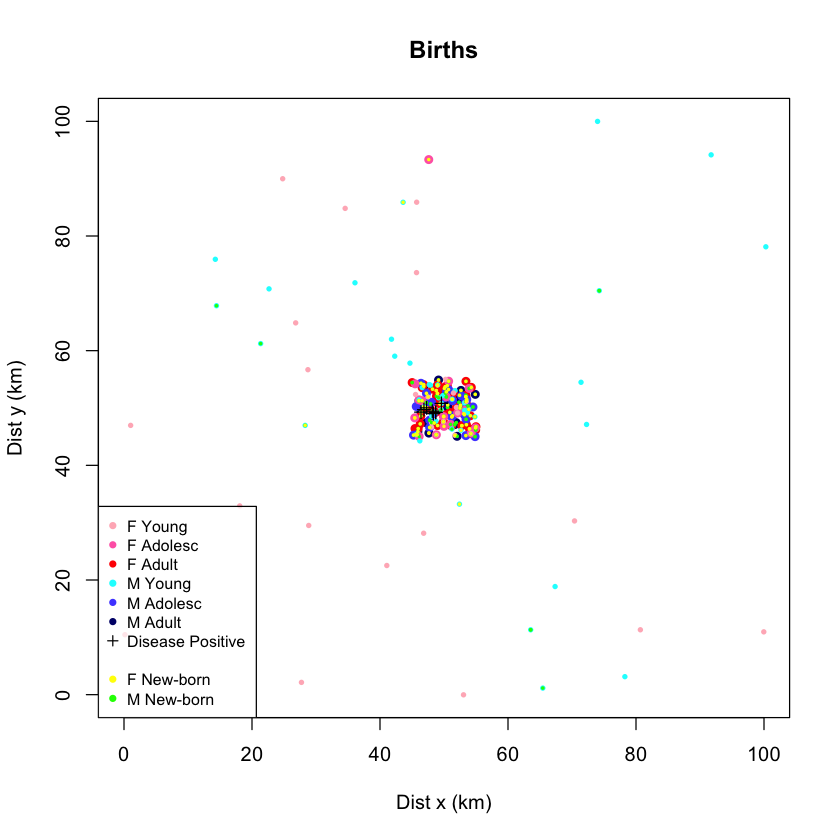

In [59]:
# PLOT
animalPlot(xWinter, yWinter, births = T, main = 'Births')

In [60]:
# Step 9: Time Lapse

#=======================================================================#
#																		#
# Increment Ages and Years Infected and set dispersedThisYear to False	#
# @param df: the Animal data.frame										#
# @return df: the updated data.frame									#
#																		#
#=======================================================================#
timeLapse = function(df) {
	df$age[df$age == 'Adol'] = 'Ad'
	df$age[df$age == 'Yng'] = 'Adol'
	df$age[df$age == 'neo'] = 'Yng'
	df$yearsInfected = df$yearsInfected + 1
	df$dispersedThisYear[1:length(df$dispersedThisYear)] = F
	
	return(df)
}

In [61]:
detach(Animal.df)
Animal.df = timeLapse(Animal.df)
attach(Animal.df)

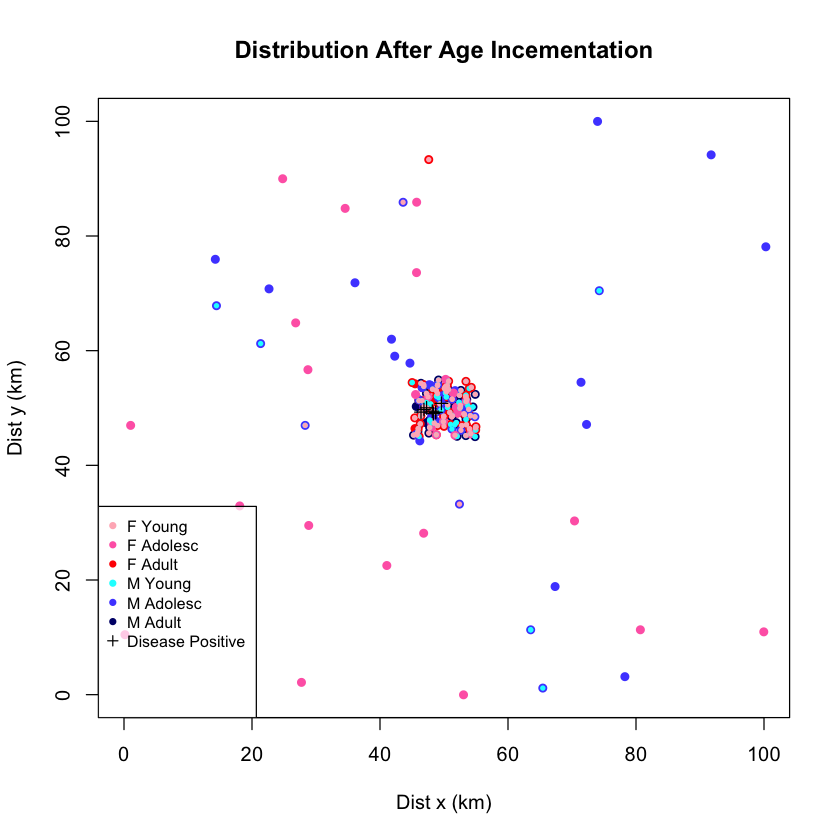

In [62]:
# PLOT
animalPlot(xWinter, yWinter, main = 'Distribution After Age Incementation')

In [63]:
# Step 10: Diminish Infectious Content in Soil

#=======================================================================#
#																		#
# Erode Soil infectiousness												#
# @param soil.M: the martrix representing the current soil load status	#
# @param soilRetentionsFactor: as set in the constant 					#
#							   SOIL_RETENTION_RATE--the fraction of the	#
#							   infectious load that is retained annualy #
# @return soil.M: the updated soil matrix								#
#																		#
#=======================================================================#
erode = function(soil.M, soilRetentionFactor = SOIL_RETENTION_RATE) {
  soil.M = soil.M * soilRetentionFactor
  return (soil.M)
}

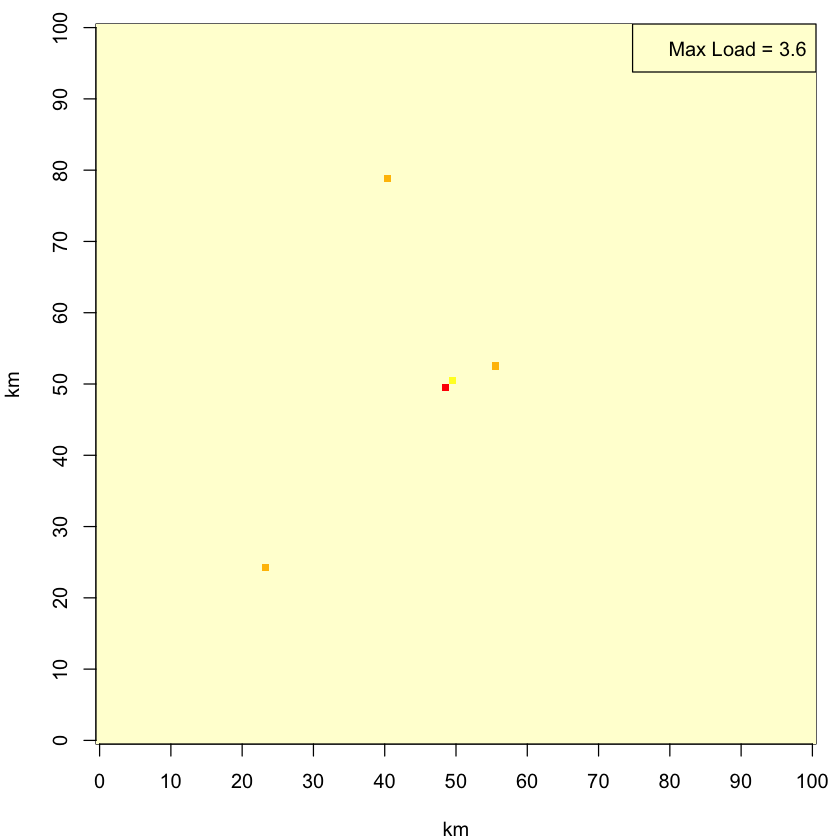

In [64]:
# Apply
soil.M = erode(soil.M)

# Plot
soilPlot()

In [65]:
# Step 11: Initialize Data Tables
# Create tables to track: 
	# Age, Sex Class and Total Deer
	# Each of the same by proportion
	# Overall prevelance of disease
	# Max load in soil

demographics.df = data.frame(
	t0 = c(length(sex[sex == 'M' & age == 'Yng']), 
		   length(sex[sex == 'M' & age == 'Adol']), 
		   length(sex[sex == 'M' & age == 'Ad']), 
		   length(sex[sex == 'F' & age == 'Yng']), 
		   length(sex[sex == 'F' & age == 'Adol']), 
		   length(sex[sex == 'F' & age == 'Ad']))
)
		   
rownames(demographics.df) = c(
    'M_Yng', 'M_Adolesc', 'M_Ad', 'F_Yng', 'F_Adolesc', 'F_Ad')
demographics.df

t0 
M_Yng     108
M_Adolesc  49
M_Ad       45
F_Yng      95
F_Adolesc  34
F_Ad       70

In [66]:
prevalence.df = data.frame(
	t0 = c(sum(diseaseStatus == 'pos'), sum(diseaseStatus == 'neg'))
)
rownames(prevalence.df) = c('pos', 'neg')
prevalence.df

t0 
pos   8
neg 393

In [67]:
# Also keep a list of the soil matrices
soil.M = soilMatrix(MAP_X, MAP_Y, MAP_UNIT, infX = NA, infY = NA)
soil.M.list = list(soil.M)
maxLoad = c()

In [68]:
# Step 12: Iterate

ITERATIONS = 1000
PLOT = F
VERBOSE = F	# If True will output progress of the following for loop
# use MAX_DEER to break loop--if disease disappears growth will take off under 
# many conditions
MAX_ANIMALS = 25000

detach(Animal.df)

In [69]:
for (iter in 1:ITERATIONS) {
	# Break if too many animals
	if (nrow(Animal.df) > MAX_ANIMALS) { break }
	
	# Output Progress
	if (VERBOSE) {
		print(iter / ITERATIONS)
	}
	attach(Animal.df)
	
	if (PLOT) {
		animalPlot(xWinter, yWinter, main = '')
		pause()
	}
	
	# Determine post-dispersal coordinates
	disperseData = disperse(age, sex, xWinter, yWinter, dispersed)
	detach(Animal.df)
	Animal.df$dispersed = disperseData$dispersed
	Animal.df$xSummer = disperseData$xSummer
	Animal.df$ySummer = disperseData$ySummer
	Animal.df$dispersedThisYear = disperseData$dispersedThisYear
	attach(Animal.df)

	# Determine post-summer-migration coordinates
	summerMigrationData = migrateToSummer(
		age, sex, xWinter, yWinter, xSummer, ySummer, dispersed, 
		dispersedThisYear
	)
	detach(Animal.df)
	Animal.df$xSummer = summerMigrationData$xSummer
	Animal.df$ySummer = summerMigrationData$ySummer
	attach(Animal.df)
	rm(summerMigrationData)
	
	if (PLOT) {
		arrows(xWinter, yWinter, xSummer, ySummer, angle = 15, length = 0.15,
			   col = rgb(0, 0, 0, 0.3))
		addLegend()
		pause()

		# Plot post-dispersal/summerMigration coordinates
		animalPlot(xSummer, ySummer, 
				   main = 'Distribution after Dispersal and Migration')
		pause()
	}
	
	# Calculate Range Radii
	rangeData = calculateRanges(sex, age)
	detach(Animal.df)
	Animal.df$postrutRM = rangeData$postrutRM
	Animal.df$prerutRM = rangeData$prerutRM
	Animal.df$rutRM = rangeData$rutRM
	Animal.df$prebreedingRF = rangeData$prebreedingRF
	Animal.df$postbreedingRF = rangeData$postbreedingRF
	Animal.df$parturitionRF = rangeData$parturitionRF
	Animal.df$maxRadius = pmax(
		Animal.df$postrutRM, Animal.df$prerutRM, Animal.df$rutRM, 
		Animal.df$prebreedingRF, Animal.df$postbreedingRF, 
		Animal.df$parturitionRF
	)
	attach(Animal.df)
	MAX_RANGE = max(maxRadius)

	if (PLOT) {
		rangePlot(xSummer, ySummer)
		pause()
	}

	# Infect Soil
	infX = xSummer[diseaseStatus == 'pos']
	infY = ySummer[diseaseStatus == 'pos']
	soil.M = soilMatrix(infX,infY, soilMatrix.M = soil.M)
	rm(infX, infY)
	soil.M.list = c(soil.M.list, list(soil.M))
	maxLoad = c(maxLoad, max(soil.M))
	
	if (PLOT) {
		soilPlot()
		pause()
	}

	# Infect other deer
	# Animal-to-animal
	newPos = animalInfect(disease.status = diseaseStatus, x = xSummer, 
						  y = ySummer, homerange = maxRadius)
	detach(Animal.df)
	Animal.df$diseaseStatus[Animal.df$diseaseStatus == 'neg'] =
		newPos[Animal.df$diseaseStatus == 'neg']
	Animal.df$yearsInfected[
		Animal.df$diseaseStatus == 'pos' & is.na(Animal.df$yearsInfected)
	] = 0
	attach(Animal.df)
	rm(newPos)

	# Soil-to-animal
	soilInfectData = soilInfect(soil.M, xSummer, ySummer, 
								diseaseStatus, yearsInfected)
	detach(Animal.df)
	Animal.df$diseaseStatus = soilInfectData$infected
	Animal.df$yearsInfected = soilInfectData$yearsInfected
	attach(Animal.df)

	if (PLOT) {
		animalPlot(xSummer, ySummer, 
				   main = 'Distribution of Disease after Summer Transmissions')
		pause()
	}

	# Migrate to Winter Grounds
	winterMigrationData = migrateToWinter(
		age = age, sex = sex, xWinter = xWinter, yWinter = yWinter, 
		xSummer = xSummer, ySummer = ySummer, 
		dispersedThisYear = dispersedThisYear
	)
	detach(Animal.df)
	Animal.df$xWinter = winterMigrationData$xWinter
	Animal.df$yWinter = winterMigrationData$yWinter
	attach(Animal.df)
	rm(winterMigrationData)

	if (PLOT) {
		arrows(xSummer, ySummer, xWinter, yWinter, angle = 15, length = 0.15,
			   col = rgb(0, 0, 0, 0.3))
		addLegend()
		pause()
	}
	
	# Infect Soil
	infX = xWinter[diseaseStatus == 'pos']
	infY = yWinter[diseaseStatus == 'pos']
	soil.M = soilMatrix(infX, infY, soilMatrix.M = soil.M)
	rm(infX, infY)
	soil.M.list = c(soil.M.list, list(soil.M))
	maxLoad = c(maxLoad, max(soil.M))

	if (PLOT) {
		soilPlot()
		pause()
	}
	
	# Infect other deer
	# Deer-to-deer
	newPos = animalInfect(disease.status = diseaseStatus, x = xWinter, 
						  y = yWinter, homerange = maxRadius)
	detach(Animal.df)
	Animal.df$diseaseStatus = newPos
	Animal.df$yearsInfected[
		Animal.df$diseaseStatus == 'pos' & is.na(Animal.df$yearsInfected)
	] = 0
	attach(Animal.df)
	rm(newPos)

	# Soil-to-deer
	soilInfectData = soilInfect(soil.M, xWinter, yWinter, 
								diseaseStatus, yearsInfected)
	detach(Animal.df)
	Animal.df$diseaseStatus = soilInfectData$infected
	Animal.df$yearsInfected = soilInfectData$yearsInfected
	attach(Animal.df)

	if (PLOT) {
		animalPlot(xWinter, yWinter,
				   main = 'Distribution of Disease after Winter Transmissions')
		pause()
	}
	
	# Die -- by: mortality; if yearsInfected = 2; Limit to K
	deathData = die(age, sex, yearsInfected)
	detach(Animal.df)
	Animal.df$vital = deathData
	attach(Animal.df)
	
	if (PLOT) {
		animalPlot(xWinter, yWinter, main = 'Mortalities')
		deathPlot()
		pause()
		
		animalPlot(xWinter, yWinter, mort = T,
				   main = 'Distribution after Deaths')
		pause()

		# Plot subdivisions
		divPlot()
	#	title('Mortality Due to Capacity Limits')
		pause()
	}



	# Remove Dead Animals
	detach(Animal.df)
	Animal.df = subset(Animal.df, vital == 'alive')
	attach(Animal.df)

	# Cap by Capacity at each subdivision
	# First assign to subdivisions
	subAssignData = subAssign(xWinter, yWinter)
	detach(Animal.df)
	Animal.df$xSub = subAssignData$xSub
	Animal.df$ySub = subAssignData$ySub
	attach(Animal.df)

	kCapData = kCap(xSub, ySub, vital, id)
	detach(Animal.df)
	Animal.df$vital <- kCapData
	attach(Animal.df)
	
	if (PLOT) {
		deathPlot()
		pause()
	}
	
	# Remove Dead Animals
	detach(Animal.df)
	Animal.df = subset(Animal.df, vital == 'alive')
	attach(Animal.df)

	# Reproduce
	if(length(id) == 0) { break }
	
	maxID = max(id)
	reproData = reproduce(sex, age, id, maxID, xWinter, yWinter)
	detach(Animal.df)
	Animal.df = rbind(Animal.df, reproData)
	attach(Animal.df)
	
	if (PLOT) {
		animalPlot(xWinter, yWinter, births = T, main = 'Births')
		pause()
	}
	
	#Increment Ages and Years Infected and set dispersedThisYear to False
	detach(Animal.df)
	Animal.df = timeLapse(Animal.df)
	attach(Animal.df)

	if (PLOT) {
		animalPlot(xWinter, yWinter, main = 'Age Incrementation')
		pause()
	}	
	
	# Erode Soil infectiousness
	soil.M = erode(soil.M)
	soil.M.list = c(soil.M.list, list(soil.M))
	maxLoad = c(maxLoad, max(soil.M))

	if (PLOT) {
		soilPlot()
	}
	
	# calculate annual statistics
	demog = c(length(sex[sex == 'M' & age == 'Yng']), 
			  length(sex[sex == 'M' & age == 'Adol']), 
			  length(sex[sex == 'M' & age == 'Ad']), 
			  length(sex[sex == 'F' & age == 'Yng']), 
			  length(sex[sex == 'F' & age == 'Adol']), 
			  length(sex[sex == 'F' & age == 'Ad']))
	demographics.df = cbind(demographics.df, demog)
	names(demographics.df)[iter + 1] = paste('t', iter, sep = '')
	
	prev = c(sum(diseaseStatus == 'pos'), sum(diseaseStatus == 'neg'))
	prevalence.df = cbind(prevalence.df, prev)
	names(prevalence.df)[iter + 1] = paste('t', iter, sep = '')
	
	detach(Animal.df)

}

In [70]:
# Step 13: Calculate and Output Stats

demogDims = dim(demographics.df)
prevDims = dim(prevalence.df)

In [71]:
# Make a table of demographics converted into proportions
demogProps.df = demographics.df
for(i in 1:demogDims[2]) {
	demogProps.df[, i] = demogProps.df[, i] / sum(demogProps.df[, i])
}

In [72]:
# ...and for prevalence
for(i in 1:prevDims[2]) {
	prevalence.df[, i] = prevalence.df[, i] / sum(prevalence.df[, i])
}

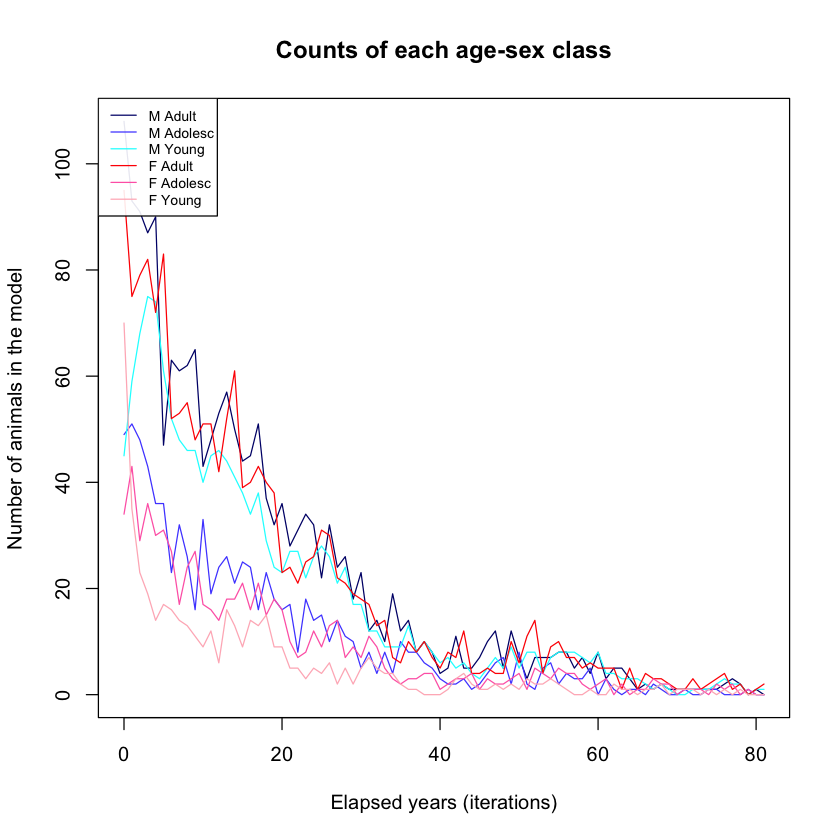

In [73]:
# Plot demographics as raw numbers:
matplot(0:(demogDims[2] - 1), t(demographics.df), type = 'l', lty = 1,	
		col = c(colorMatrix[1, -4], colorMatrix[2, -4]),
		main = 'Counts of each age-sex class', 
		xlab = 'Elapsed years (iterations)', 
		ylab = 'Number of animals in the model')
legend('topleft', 
	   legend=c('M Adult', 'M Adolesc', 'M Young', 
	   			'F Adult', 'F Adolesc', 'F Young'), 
	   	lty = 1, col = c(colorMatrix[1, -4], colorMatrix[2, -4]), cex = 0.7,
	   	bg = rgb(1, 1, 1, 0.9))


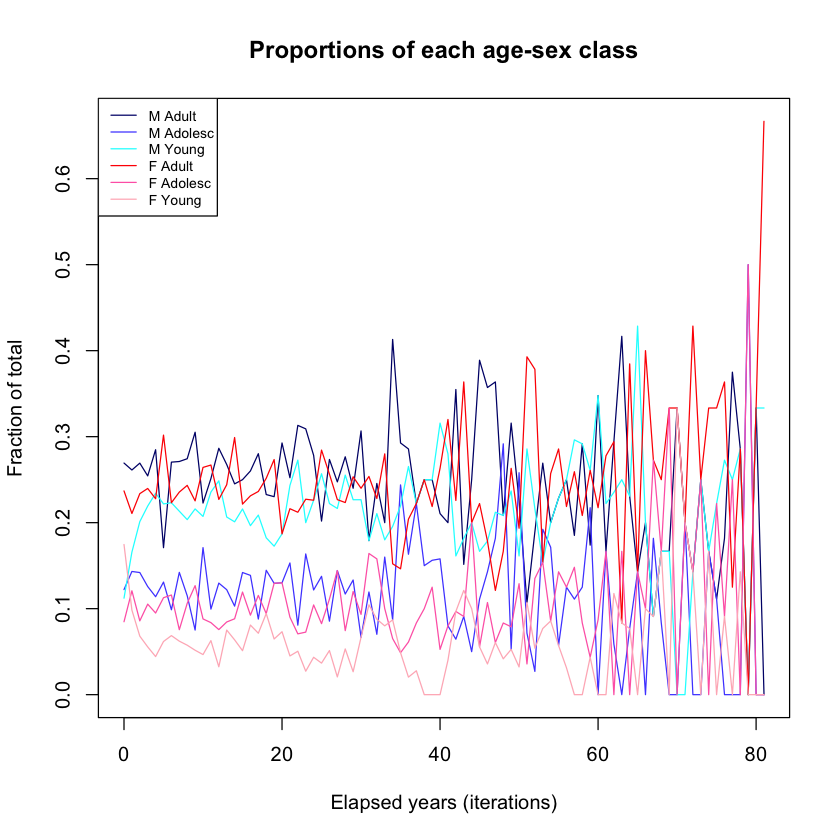

In [74]:
# Plot same as proportions:
matplot(0:(demogDims[2] - 1), t(demogProps.df), type = 'l', lty = 1,
		col = c(colorMatrix[1, -4], colorMatrix[2, -4]), 
		main = 'Proportions of each age-sex class', 
		xlab = 'Elapsed years (iterations)', ylab = 'Fraction of total')
legend('topleft', 
	   legend=c('M Adult', 'M Adolesc', 'M Young', 
	   			'F Adult', 'F Adolesc', 'F Young'), 
	   lty = 1, col = c(colorMatrix[1, -4], colorMatrix[2, -4]), cex = 0.7,
bg = rgb(1, 1, 1, 0.9))

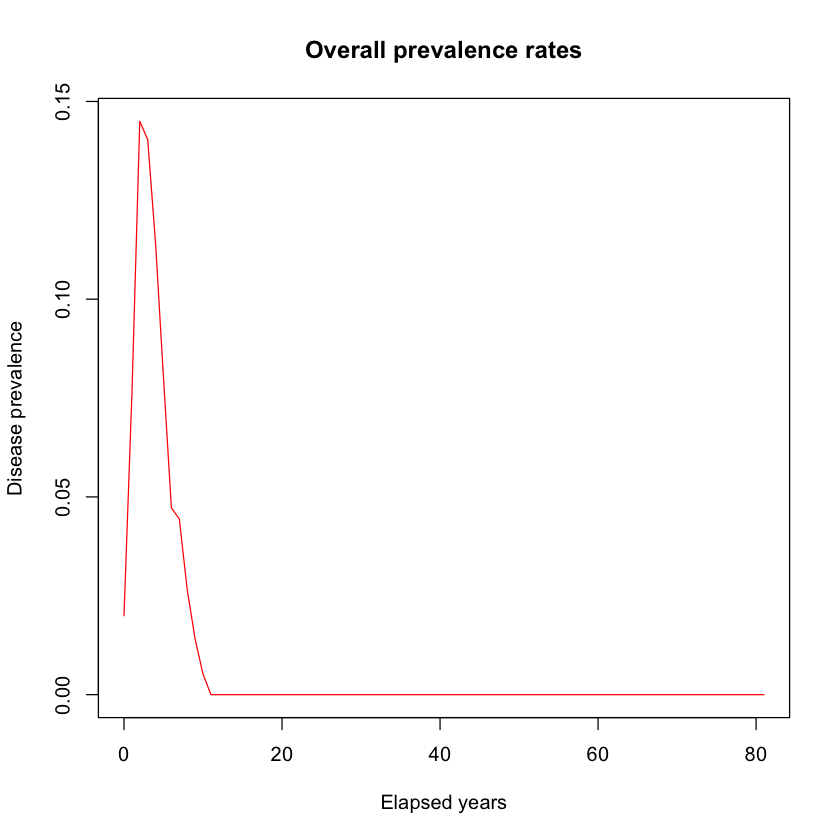

In [75]:
# Plot prevalence counts
matplot(0:(prevDims[2] - 1), t(prevalence.df)[, 1], type = 'l', lty = 1,
	 	main = 'Overall prevalence rates', 
	 	xlab = 'Elapsed years', ylab = 'Disease prevalence', col = 2)

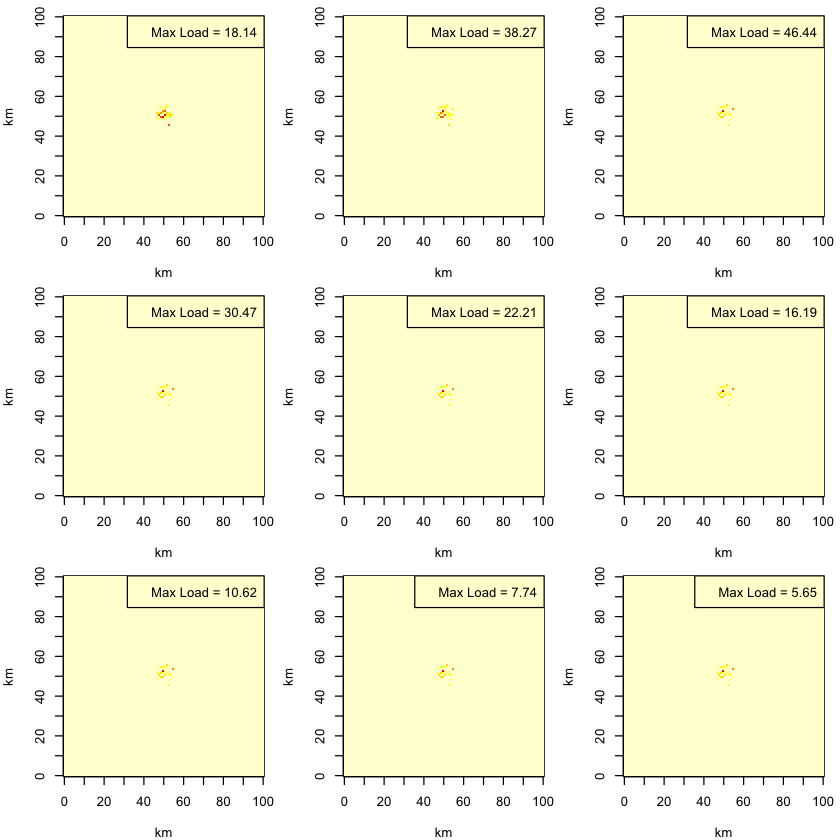

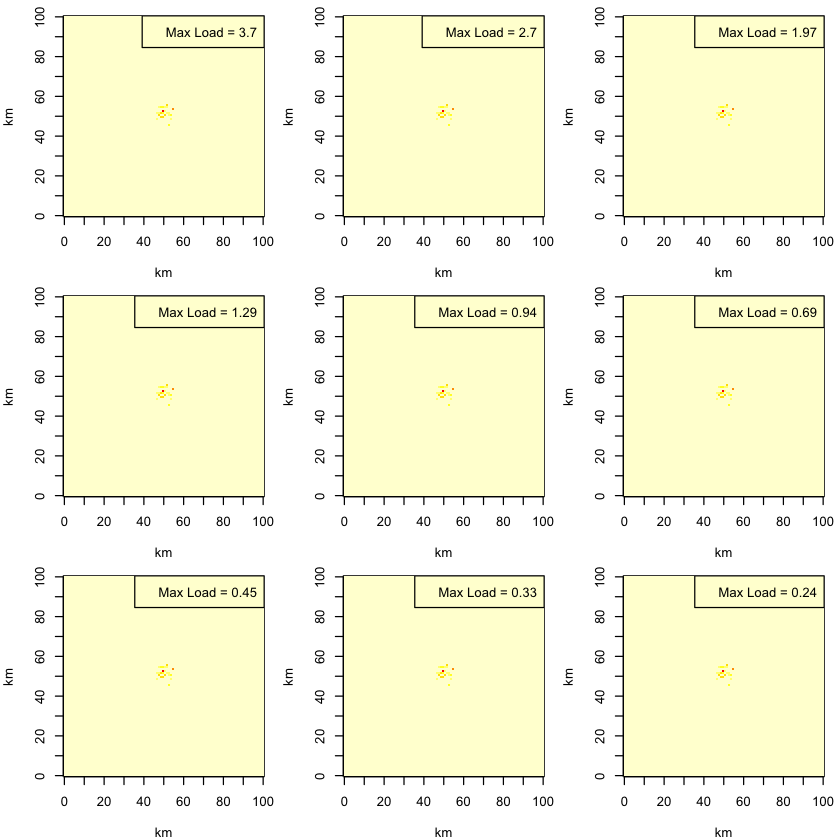

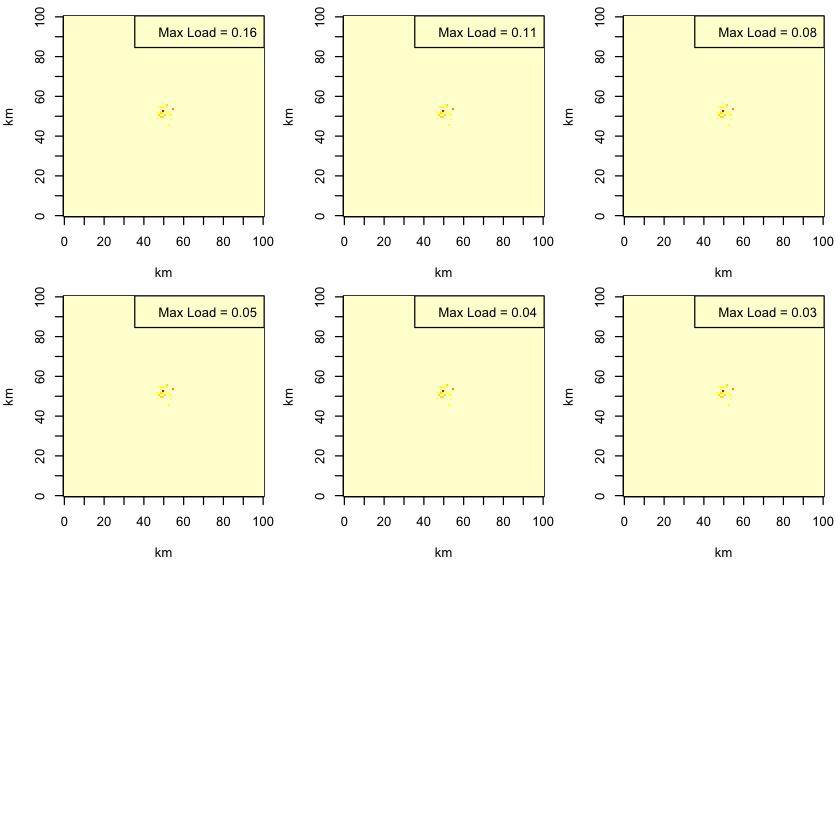

In [76]:
# Plot soil maps
par(mfrow = c(3, 3))

for(i in 1:length(soil.M.list)) {
    if (i %% 10 == 0) {
      soilPlot(soil.M.list[[i]])
    }
}

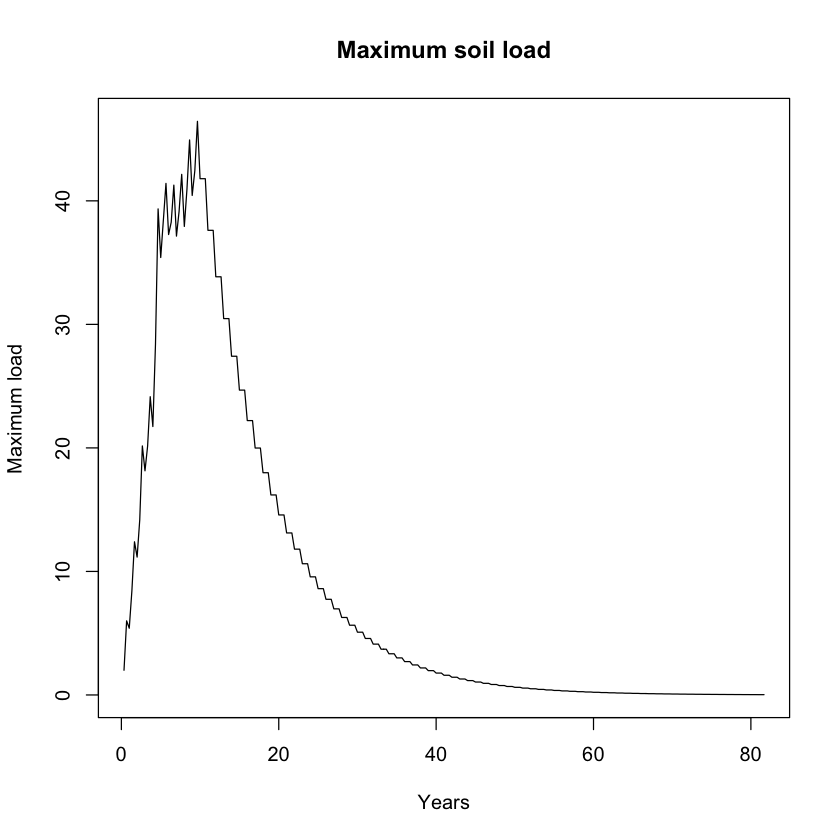

In [77]:
par(mfrow = c(1, 1))

# Plot maxLoad
plot((1:length(maxLoad)) / 3, maxLoad, type = 'l', main = "Maximum soil load", 
xlab = 'Years', ylab = 'Maximum load')

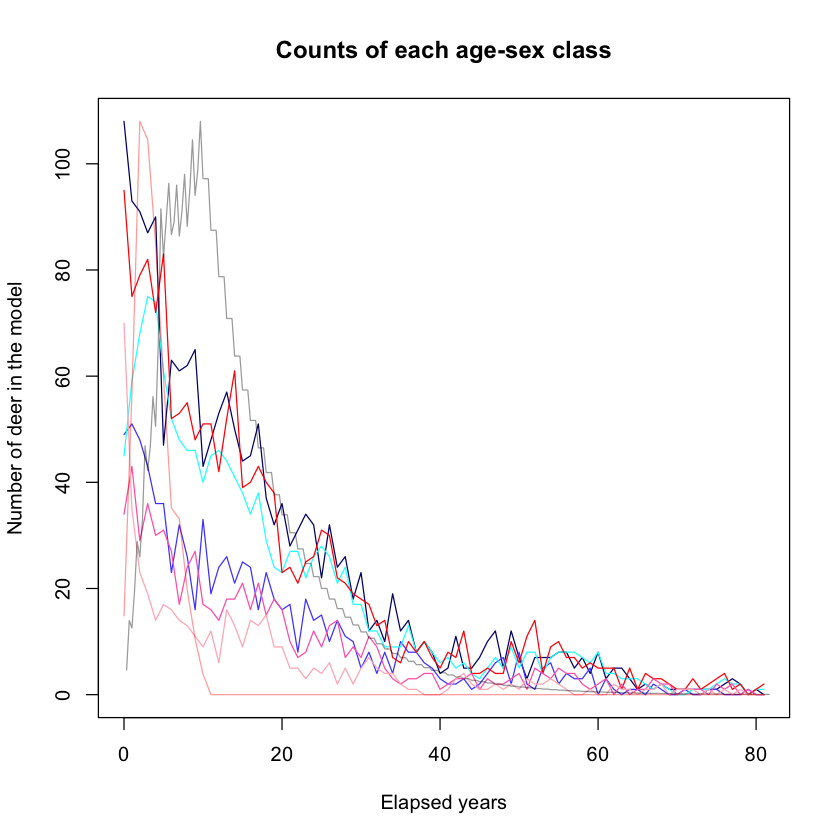

In [78]:
# Superimpose
matplot(0:(demogDims[2] - 1), t(demographics.df), type = 'l', lty = 1,	
		col = c(colorMatrix[1, -4], colorMatrix[2, -4]),
		main = 'Counts of each age-sex class', 
		xlab = 'Elapsed years', ylab = 'Number of deer in the model')
ml.max = max(maxLoad)
prev.max = max(prevalence.df[1, ])
loadScaler = max(demographics.df) / ml.max
prevScaler = max(demographics.df) / prev.max
lines((1:length(maxLoad)) / 3, loadScaler * maxLoad, col = rgb(0, 0, 0, 0.4))
ts = 0:(length(prevalence.df[1, ]) - 1)
lines(prevScaler * as.numeric(prevalence.df[1, ]) ~ ts, 
col = rgb(1, 0, 0, 0.4))

In [ ]:
# Housekeeping

# To save the data to the working directory:
#save.image("simDeer.RData")

# Clear the workspace:
detach(Animal.df)
rm(list = ls())